<center>Национальный исследовательский университет ИТМО<br/>Факультет информационных технологий и программирования<br/>Прикладная математика и информатика</center>

## <center>**Методы оптимизации**</center>
### <center>Отчёт по лабораторной работе №2</center>

<div style="text-align: right"><b>Работу выполнили:</b><br/>Левицкий Иван M32351<br/>Шпрайдун Лев M32351<br/>Рынк Артур М32351<br/><b>Преподаватель:</b><br/>Ким С.Е.</div>

<center>Санкт-Петербург<br/>2023</center>

#**Постановка задачи и цели работы:**

№1) Реализовать стохастический градиентный спуск для решения линейной регрессии.

№1.1) Исследовать сходимость с разным размером батча (1 - SGD, 2, ... n-1 - Minibatch GD, n - GD).

№2) Подобрать и проанализировать экспоненциальную(ступенчатую) функцию изменения шага (lerning rate scheduling).

№3) Исследовать модификации градиентного спуска а (Nesterov, Momentum, AdaGrad, RMSProp, Adam).

№4) Исследовать сходимость алгоритмов. Сравнить различные методы по скорости, надежности, требуемым машинным ресурсам (объем оперативной памяти, количество арифметических операций, время выполнения).

№5) Построить траекторию спуска различных алгоритмов из одной и той же исходной точки с одинаковой точностью. Наложить эту траекторию на рисунок с линиями равного уровня заданной ф-ции.

**ДОП.**

№6) Реализовать полиномиальную регрессию.

№6.1) Построить графики восстановленной регрессии для полиномов разной степени.

№7.1) Модифицировать полиномиальную регрессию добавлением регуляризации в модель (продемонстрировать L1, L2, Elastic регуляризации).

№7.2) Провести эксперименты и тем самым исследовать влияние регуляризации на восстановление регрессии.

**Работа выполнена при помощи следующих библиотек:**

 1) numpy (в основном для упрощения операций над матрицами и массивами)

 2) matplotlib.pyplot для отрисовки графиков

In [ ]:
import numpy as np
from numpy.ma.core import shape
from functools import *
import matplotlib.pyplot as plt

import tqdm
plt.rcParams["figure.figsize"] = (25, 5)


In [ ]:
def print_gradient_work(points, f, num=25, custom_plt=plt):
  x = np.linspace(np.min(points[:, 0]) - 0.01, np.max(points[:, 0]) + 0.01, num)
  y = np.linspace(np.min(points[:, 1]) - 0.01, np.max(points[:, 1]) + 0.01, num)
  X = np.meshgrid(x, y)

  custom_plt.contourf(X[0], X[1], f(X), levels=np.sort(f(points.T)))
  custom_plt.plot(points[:, 0], points[:, 1], 'o-', color=(0.8, 0.3, 0.2))

##**Определение стохастического градиентного спуска**

**Линейная регрессия** в общем виде - некоторая последовательость пар $(x_i, y_i)$, задающих с какой-то дисперсией функцию $f$ вида $f=kx + b$, где $x,k \in R^n$, $y_i \in R$, то есть $x-n$-мерная точка, а $y_i=f(x_i)+ϵ_i$.

**Функция потери на одном элементе** - это некоторая ф-ция $L(x_i, y_i, W_j)$, где $W_j-$ текущий ответ алгортма (некоторые параметры, характеризующие искомую ф-цию $f$, то есть в случае линейной регресии - коэффиценты $k_j, b_j$). На практике в основном используют $MSE-$среднеквадратическая ошибка, то есть $L(x_i, y_i, W_j)=(f_j(x_i)-y_i)^2=(W_j^T*x_i - y_i)^2$, и $MAE-$ средняя абсолютная ошибка, то есть $L(x_i, y_i, W_j)=|W_j^T*x_i - y_i|$, мы же будем пользоваться только $MSE$.

В такой нотации также значение $W_j^T*x_i - y_i$ уместно называть просто ошибкой $(error)$, так как по сути оно представляет собой значение $f_j(x_i)-y_i$ - то есть разницей между предполагаемой на данном шагу функцией и имеющимся значением в текущей точке.

**Функция потери (общая)** - функция $H$, такая, что $H(X, Y, W_j)=\frac{1}{m}\sum_{i=0}^m{L(X[i], Y[i], W_j)}$, где $X-$ массив точек $x_i$, а $Y-$ соответствующий массив значений размера $m$.

Стохастический градиент примерно оценивается следующим образом (это выводится из матожиданий): $gradH=ΔH=Δ\frac{1}{m}\sum_{i=0}^m{L(X[i], Y[i], W_j)}=\frac{1}{m}\sum_{i=0}^m{ΔL(X[i], Y[i], W_j)}$. А градиент $L$ мы уже можем явно посчитать в случае $MSE$.

**Задачей стохастического градиентного спуска** $(SGD)$ является минимизация ф-ции $H$ (уменьшение ошибки/потерь), посредством движения вдоль ее антиградиента (в этом смысле он очень похож на классический градиентный спуск $(GD)$), с тем лишь отличием, что спуск происходит не по всем координатам сразу, а по некоторому случайному их подмножеству размера $B=batch$ (в этом случае $m$ из формул выше и есть $B$).

Пересчет в общем виде выполняется классически $W_{j+1}=W_j-λ_jΔH(X_{σ}, Y_{σ}, W_j)$, где $σ-$ некоторая рандомная выборка размера $batch$. Но различные модификации классического $SGD$ обычно задают пересчет $λ$ достаточно сложным, из-за чего пересчет $W_{j+1}$ может задаваться дополнительными последовательностями (далее $G_j$ и $v_j$) и несколько видоизменяться, хотя суть остается таковой.

В случае решения линейной регрессии $W_j$ - понятным образом представляет собой коэффициенты искомой линейной ф-ции $f_j$, и $SGD$ по итогу с некоторой точностью $ϵ=epsstop$ за некоторое кол-во эпох $epochs$ выдает искомые коэффициенты $k$ и $b$.

Мы останавливаемся если значение $H$ (минимизируемой ф-ции) становится меньше  $epsstop$ (можем действовать и в режиме без остановки) или прошло установленное кол-во эпох.

In [ ]:
def L(x, y, W):
  return (W[0] @ x + W[1][-1] - y) ** 2

def H(X, Y, W):
  m = Y.shape[0]
  sum = 0
  for i in range(Y.shape[0]):
    sum += L(X[i], Y[i], W)
  return 1/m * sum

def L_paint_2(x, y, W):
  return (W[0] * x + W[1] - y) ** 2

def H_paint_2(X, Y, W):
  m = Y.shape[0]
  sum = 0
  for i in range(Y.shape[0]):
    sum += L_paint_2(X[i], Y[i], W)
  return 1/m * sum

def gradL(x, y, W):
  z = np.zeros(W.shape[1])
  z[-1] = 1
  return np.array([
          2 * (W[0] @ x + W[1][-1] - y) * x,
          2 * (W[0] @ x + W[1][-1] - y) * z])

def gradH(X, Y, W):
  sum = [np.zeros(W.shape[1]), np.zeros(W.shape[1])]
  m = Y.shape[0]
  for i in range(Y.shape[0]):
    sum += gradL(X[i], Y[i], W)
  return 1/m * sum

def SGD_prototype(X, Y, W, lr, change_W, change_lr, epochs, batch,
                  change_G = 0,
                  change_V = 0,
                  beta_1 = 0, beta_2 = 0, eps_stop = -1):
  cur_epoch = 0
  n = len(X)
  v = W
  g = W

  ###отрисовка
  weights_paint=[]
  losts=[H(X, Y, W)]
  ###

  while (cur_epoch <= epochs and (eps_stop == -1 or H(X, Y, W) > eps_stop)):
    cur_epoch+=1
    rand_permut = np.random.permutation(n)
    X_s = X[rand_permut]
    Y_s = Y[rand_permut]
    for i in range(0, n, batch):
      X_i = X_s[i:i+batch]
      Y_i = Y_s[i:i+batch]

      #доп последовательности
      if change_V != 0:
        v = change_V(v, beta_1, lr, W, X_i, Y_i)
      if change_G != 0:
        g = change_G(v, g, beta_2, W, X_i, Y_i)

      #пересчет
      W = change_W(X_i, Y_i, W, v, g, lr)
    lr = change_lr(lr, cur_epoch)

    #для отрисовки
    weights_paint.append([W[0][0], W[1][0]])
    losts.append(H(X, Y, W))
  W = [W[0].tolist(), W[1][-1]]
  return W, weights_paint, losts, cur_epoch

###**№1) Реализация SGD (без модификаций).**

Обычный $SGD$ вполне тривиален. В ходе его работы $λ=const$, никаких дополнительных п-тей мы не пересчитываем. Может сходится в определенных случаях дольше своих модификаций в силу того, что $λ-$ не изменяется. Однако имеет и преимущества, т.к. менее нагружен и бывает, что на первых шагах нам хочется достаточно большу $λ$.

Понятное дело пересчет обычный: $W_{j+1}=W_j-λ_jΔH(X_{σ}, Y_{σ}, W_j)$

Как и все $SGD-$ имеет сильный шум в ходе работы, что будет продемонстрировано на графиках (см пункт 5) и может неккоректно завершаться при плохо подобранной $λ$, испытывая арифметические переполнения.


In [ ]:
def SGD(X, Y, W, lr, epochs = 100, batch = 1, eps_stop=-1):
  return SGD_prototype(X, Y, W, lr,
                       (lambda X_i, Y_i, W, v, g, lr : W - lr * gradH(X_i, Y_i, W)),
                       (lambda lr, epochs : lr), epochs, batch, eps_stop=eps_stop)

**Демонстрация работы, с выводом получившихся значений.**

(Уже можно сделать понятный вывод, что при большем кол-ве предоставленных точек, полученный ответ получается гораздо точнее при равном кол-ве эпох)

In [ ]:
# y = kx + b, k= 1, b=0

print("y = x")
print("W1 =", SGD(np.array([[1], [2], [3]]),
          np.array([[1], [2], [3]]),
           np.array([[0], [0]]), 0.001, 1000, 1)[0])

print("W2 =", SGD(np.array([[1], [2], [3], [4], [5], [6], [7], [8]]),
          np.array([[1], [2], [3], [4], [5], [6], [7], [8]]),
           np.array([[0], [0]]), 0.001, 1000, 1)[0])

print("y = [1, 1, 1, 1] * x")
# y = kx + b, k=[1, 1, 1, 1], b=0
print("W3 =", SGD(np.array([[1, 2, 1, 1], [2, 7, 2, 2], [-10, 3, 3, 3]]),
          np.array([[5], [13], [-1]]),
           np.array([[0, 0, 0, 0], [0, 0, 0, 0]]), 0.001, 1000, 1)[0])

print("W4 =", SGD(np.array([[1, 2, 1, 1], [2, 7, 2, 2], [-10, 3, 3, 3], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]),
          np.array([[5], [13], [-1], [1], [1], [1], [1]]),
           np.array([[0, 0, 0, 0], [0, 0, 0, 0]]), 0.001, 1000, 1)[0])

print("W5 =", SGD(np.array([[1, 2, 1, 1], [2, 7, 2, 2], [-10, 3, 3, 3], [1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [5, -5, 5, -5], [10, -5, 10, 5]]),
          np.array([[5], [13], [-1], [1], [1], [1], [1], [0], [20]]),
           np.array([[0, 0, 0, 0], [0, 0, 0, 0]]), 0.001, 1000, 1)[0])

y = x
W1 = [[0.9215882096403275], 0.17842502327235907]
W2 = [[0.998799547638713], 0.006763425850252902]
y = [1, 1, 1, 1] * x
W3 = [[0.8406661875057102, 1.2470194925172216, 0.522555511881456, 0.522555511881456], 0.5286628448766424]
W4 = [[0.9508204656613148, 1.079174064717066, 0.8627747029666349, 0.8628085193398219], 0.0950554435147246]
W5 = [[1.0000025467897746, 0.9999690505670085, 0.9999503966693463, 1.0000233449352915], 0.00018717109805500653]


###**№1.1) Исследование сходимости с разным размером батча.**

Для начала реализуем генерацию $n$-мерной линейной регрессии, с заданным разбросом аргументов, и, главное, с заданной дисперсией самих значений ф-ции.

Привиденная ниже реализация принимает на вход желаемые $k$ и $b$, $count-$ желаемое кол-во точек в регрессии, $dispx-$ разброс аргументов и $disp$ - дисперсию значений от задуманной прямой.

Т.к. np.random.uniform() по дефолту является равномерным распределением, а мы передаем ему аргументы $[-disp$, $disp]$, то получаем итоговую дисперсию $\frac{2(disp)^2}{12}$, т.к. формула дисперсии нормального распределения на отрезке $[a, b]$ это $\frac{(b-a)^2}{12}$. Из-за чего везде далее нам следует ожидать (выставлять) точность работы не выше данного значения.

In [ ]:
#Генерация n-мерных точек
def random_n_linear_regression(k, b, count, dispx=100, disp=3):
  n=len(k)
  x = np.random.rand(count, n) * dispx
  X = []
  y = []
  for i in x:
    X.append(i)
    y.append([k @ i + b + np.random.uniform(-disp, disp)])
  return np.array(X), np.array(y), np.array([[0 for i in range(n)], [0 for i in range(n)]])

**Эксперимент 1.**

Первым экспериментом продемонстрируем зависимость между потерями $(H)$ и номером эпохи для маленьких батчей при очень большой выборке точек (суть не в том, чтобы сойтись до конца, а, чтобы показать различия в сходимости на начальном этапе).


**Вывод:**

Зависимость $H(epoch)$ - гиперболическая. Ясно видно, что, чем меньше $batchsize$, тем резче спуск, из чего уже, очевидно, что с точки зрения нахождения приблизительного результата (то есть используя малое число эпох) нам выгоднее использовать меньший $batchsize$.

100%|██████████| 6/6 [00:09<00:00,  1.66s/it]


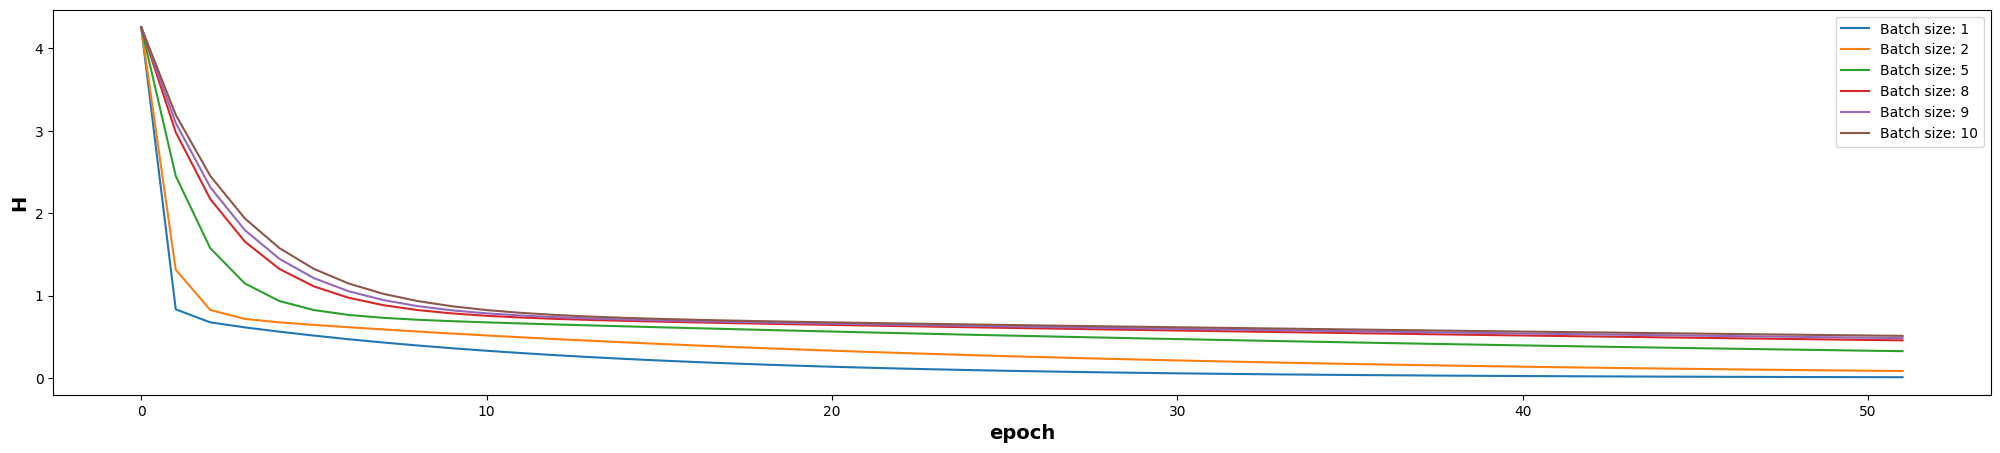

In [ ]:
###1.1 different_batch
batch_sizes = [1, 2, 5, 8, 9, 10]
full_losts = []

k = (np.random.random(1) / 10).tolist()
x, y, start_W = random_n_linear_regression(k, 2, 1000, dispx=5, disp=0.01)
for bs in tqdm.tqdm(batch_sizes):
  _, _, losts, _ = SGD(x, y, start_W, 0.0001, 50, bs)
  full_losts.append(losts)

for i, bs in enumerate(batch_sizes):
  plt.plot(full_losts[i], label=f"Batch size: {bs}")
plt.legend()
plt.ylabel("H", fontsize=14, fontweight="bold")
plt.xlabel("epoch", fontsize=14, fontweight="bold")
plt.show()

**Эксперимент 2.**

Вторым экспериментом продемонстрируем ту же зависимость для больших батчей (с большим разбросом между ними).

100%|██████████| 9/9 [00:11<00:00,  1.30s/it]


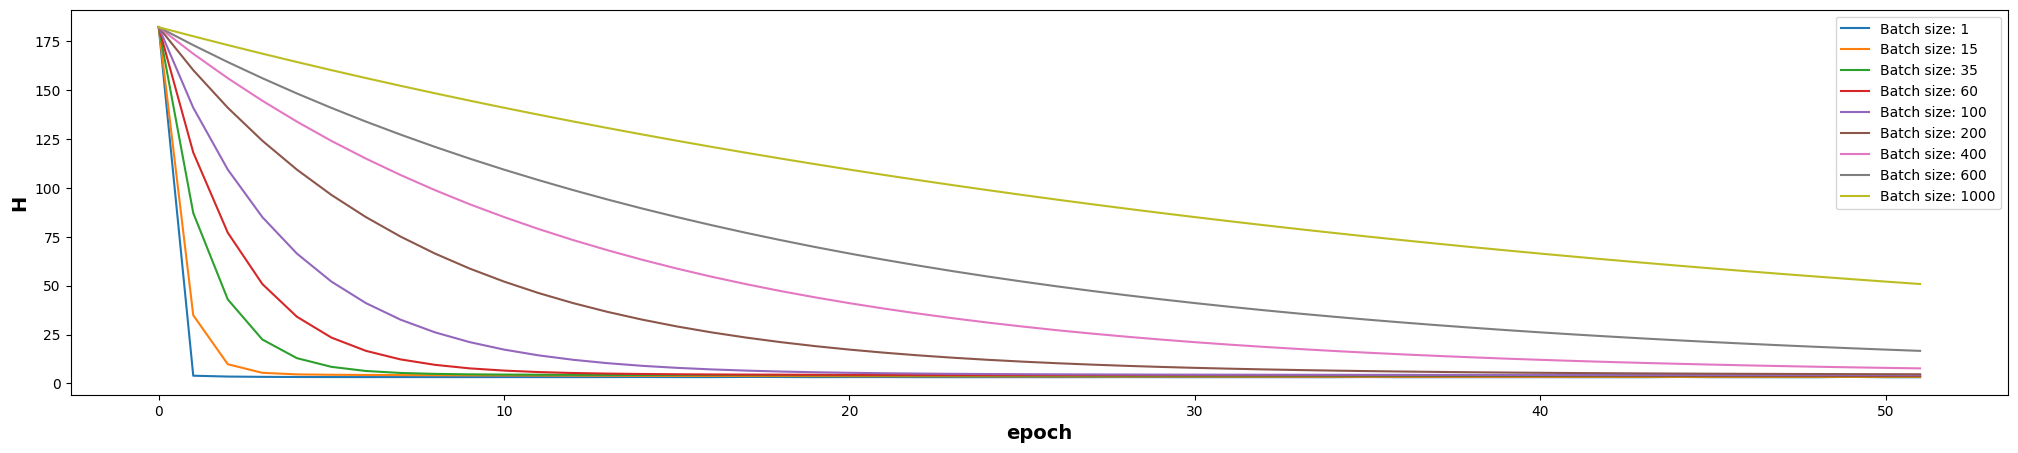

In [ ]:
###1.2 different_batch
batch_sizes = [1, 15, 35, 60, 100, 200, 400, 600, 1000]
full_losts = []
k = (np.random.random(10)).tolist()
x, y, start_W = random_n_linear_regression(k, 2, 1000, dispx=5)
for bs in tqdm.tqdm(batch_sizes):
  _, _, losts, _ = SGD(x, y, start_W, 0.0001, 50, bs)
  full_losts.append(losts)

for i, bs in enumerate(batch_sizes):
  plt.plot(full_losts[i], label=f"Batch size: {bs}")
plt.legend()
plt.ylabel("H", fontsize=14, fontweight="bold")
plt.xlabel("epoch", fontsize=14, fontweight="bold")
plt.show()

**Эксперимент 3.**

Третьим экспериментом продемонстрируем зависимость между батчем и кол-вом эпох, требуемых для сходимости с заданной точностью на регрессии из $1002$ $10$-мерных точек с разбросом $[-0.1, 0.1]$ от прямой.

**Вывод:**

Получили линейно-ступенчатую зависимость $count\_epochs$ от $batchsize$. Это говорит нам о том, что в поиске ответа желаемой точности нам выгоднее в итоге использовать меньший $batchsize$ (при условии, что данного $batchsize$ в принципе хватает для сходимости (см. эксперимент 4)).

Результат достаточно логичен в том смысле, что увеличивая $batchsize$ (с некоторого батча при котором мы уже сходимся) мы не изменяем кол-во итераций (т.к. проход по батчу переносится внутрь вычисления потерь (функцию $H$)), а вот величина шага (пересчет) избыточно уменьшается $⇒$ для достижения той же точности нам постоянно нужно чуть большее кол-во эпох.

100%|██████████| 999/999 [10:27<00:00,  1.59it/s]


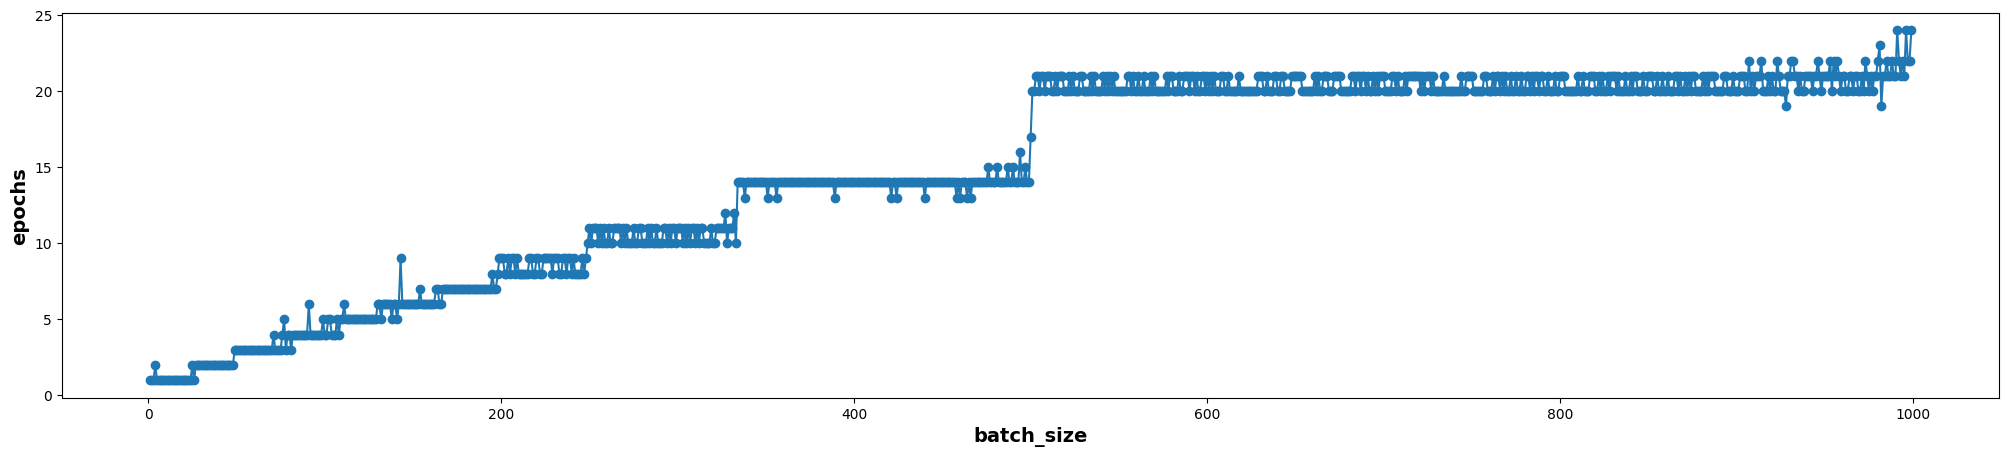

In [ ]:
###2.1 different_batch
batch_sizes = range(1, 1000, 1)
numbers_of_final_epoch = []
k = (np.random.random(10)).tolist()
d=0.1
x, y, start_W = random_n_linear_regression(k, 1, 1002, dispx=5, disp=d)
paints_batch = []
#(2*d)**2)/12
for bs in tqdm.tqdm(batch_sizes):
  _, _, _, epoch = SGD(x, y, start_W, 0.01, 5000, bs, eps_stop=(((2*d)**2)/12))
  # print(epoch)
  numbers_of_final_epoch.append([epoch])
  paints_batch.append([bs])

plt.plot(paints_batch, numbers_of_final_epoch, '-o')
plt.xlabel("batch_size", fontsize=14, fontweight="bold")
plt.ylabel("epochs", fontsize=14, fontweight="bold")
plt.show()

**Эксперимент 4.**

В четвертом эксперименте возьмем гораздо меньшую выборку ($100$) с чуть другими данными и тем же разбросом.

**Вывод:**

Как можно заметить, на совсем маленьких батчах алгоритм вполне может в принципе не сходиться (будем считать, что если мы не сошлись за 5000 эпох то мы не сошлись за разумное время).

Это логично, т.к. ф-ция потерь у нас имеет лишь приблизительный (стохастический) градиент, а значит маленького батча может не хватать для понимания общей ситуации и алгоритм может постоянно находить слишком локальные минимумы.

100%|██████████| 99/99 [07:57<00:00,  4.83s/it]


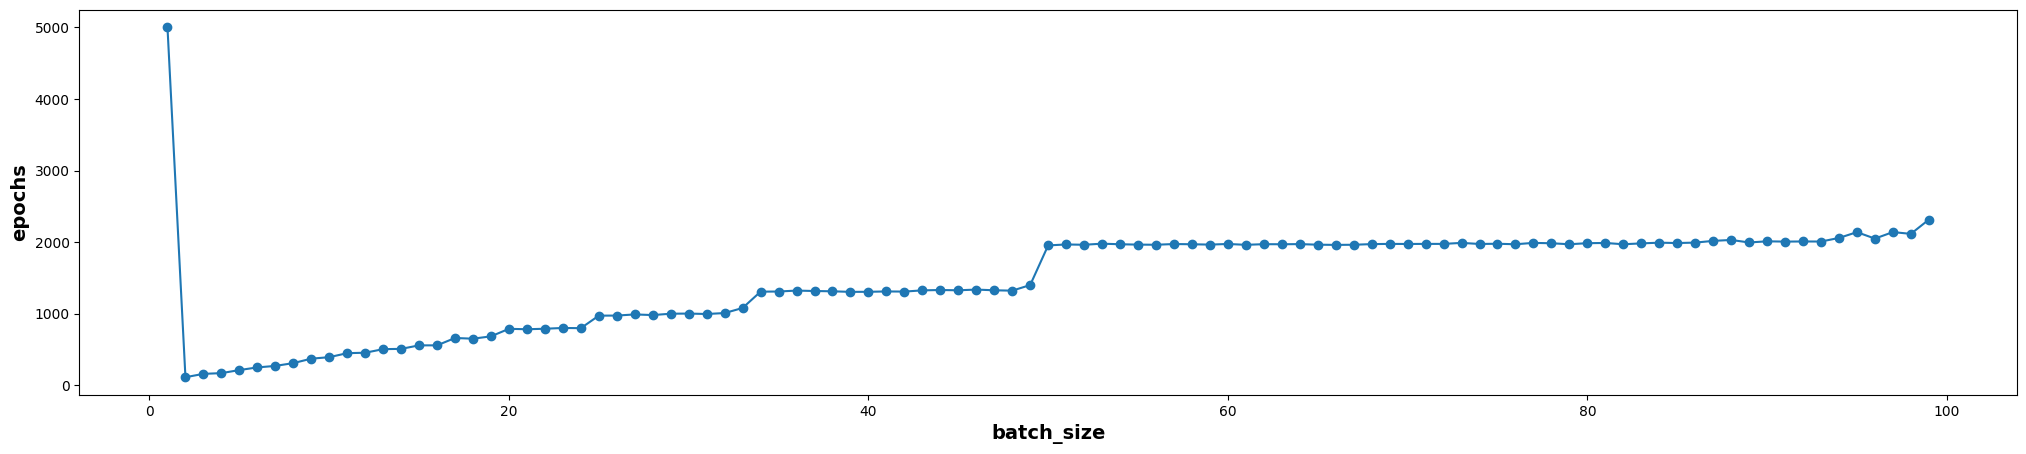

In [ ]:
###2.2 different batch
batch_sizes = range(1, 100, 1)
numbers_of_final_epoch = []
k = (np.random.random(10)).tolist()
d=0.1
x, y, start_W = random_n_linear_regression(k, 1, 100, dispx=5, disp=d)
paints_batch = []
#(2*d)**2)/12
for bs in tqdm.tqdm(batch_sizes):
  _, _, _, epoch = SGD(x, y, start_W, 0.01, 5000, bs, eps_stop=(((2*d)**2)/12))
  # print(epoch)
  numbers_of_final_epoch.append([epoch])
  paints_batch.append([bs])

plt.plot(paints_batch, numbers_of_final_epoch, '-o')
plt.xlabel("batch_size", fontsize=14, fontweight="bold")
plt.ylabel("epochs", fontsize=14, fontweight="bold")
plt.show()

####**Общий вывод по 4-ем экспериментам**:

Наиболее выгодным $batchsize$ можно считать тот, при котором спуск начинает более-менее сходиться к нужной точности. Далее повышать $batchsize$ по сути бессмысленно - это приводит только к небольшому повышению требуемого кол-ва эпох для сходимости к нужной точности.

**Примечание:**

Можно отметить, что использовать больший $batchsize$ (оптимальный) может быть еще выгодно, например, в той ситуации если перед нами стоит проблема в считывании исходной выборки (долгое обращение) и нам нужно за один раз считать некоторый буфер данных.

###**№2) SGD с экспоненциальным изменением шага.**

Идея понятна, мы хотим на каждом шаге пересчитывать $λ_k$, для того чтобы совершать меньшие скачки в пересчете $W_{k+1} = W_k-λ_k*ΔH(W_k)$.

Конкретно здесь мы хотим очень примитивный пересчет $λ_k$, а именно $λ_{k+1}=λ_k ⋅ α$, где $0<α<1-$ некоторая заранее определенная константа (понятно, что она должна быть достаточно близкой к $1$).


In [ ]:
#2
def SGD_with_exp_change_lr(X, Y, W, lr, epochs = 100, batch = 1, exp = 0.95, eps_stop=-1):
  return SGD_prototype(X, Y, W, lr,
                       (lambda X_i, Y_i, W, v, g, lr : W - lr * gradH(X_i, Y_i, W)),
                       (lambda lr, epochs : lr * exp), epochs, batch, eps_stop=eps_stop)


####**Эксперимент 1.**

Покажем сравнительное поведение $SGD$ и $SGD$ с экспоненциальной модификацией (с константой $\alpha=0.8$) на достаточно произвольном наборе данных (на котором они очень долго сходятся).

**Вывод:**

Видно, что обычный $SGD$ до последнего совершает очень сильные колебания, а модификация очень быстро снижает темп обучения в силу уменьшения влияния градиента и шагов в целом.

100%|██████████| 2/2 [00:34<00:00, 17.22s/it]


[array([10.61923563]), array([0.13223722]), array([0.19667937]), array([0.12590928]), array([0.164921]), array([0.12134352]), array([0.83551566]), array([0.23632169]), array([0.24098069]), array([0.17248943]), array([0.12281699]), array([0.15170987]), array([0.29893645]), array([0.29881435]), array([0.16950604]), array([0.11763261]), array([0.1497268]), array([0.29592423]), array([0.14554321]), array([0.35651968]), array([0.19501321]), array([0.12263091]), array([0.17079978]), array([0.2643193]), array([0.18417305]), array([0.28763954]), array([0.44048199]), array([0.14524539]), array([0.56363046]), array([0.81117515]), array([0.18939507]), array([0.20749916]), array([0.1124904]), array([0.29312281]), array([0.12562192]), array([0.40946393]), array([0.20354902]), array([0.15957615]), array([0.14134564]), array([0.14505929]), array([0.36979052]), array([0.13919987]), array([0.14676498]), array([0.14003787]), array([0.40256712]), array([0.12009883]), array([0.11922321]), array([0.3702232

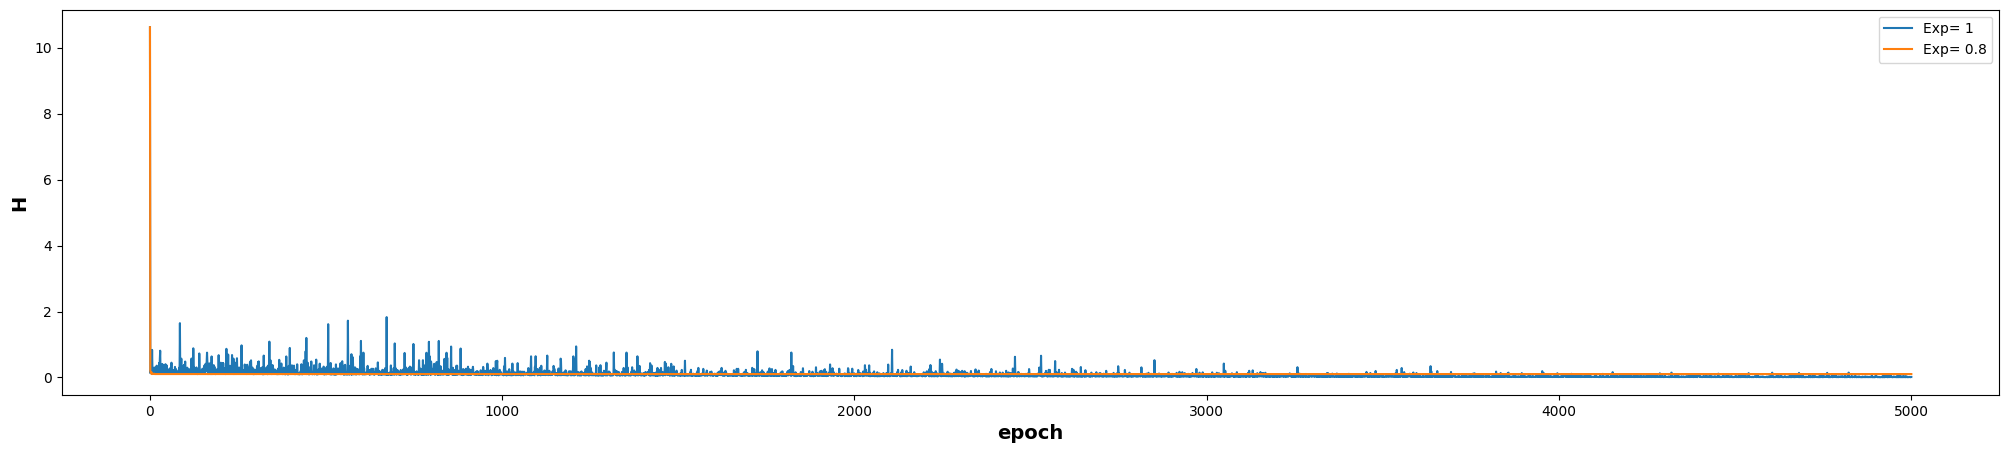

In [ ]:
###2
full_losts = []
different_exp=[1, 0.8]
k = (np.random.random(10) / 100).tolist()
d=0.01
x, y, start_W = random_n_linear_regression(k, 2, 100, dispx=50, disp=d)
for exp in tqdm.tqdm(different_exp):
  _, _, losts, _ = SGD_with_exp_change_lr(x, y, start_W, 0.0001, 5000, 2, exp, eps_stop=(((2*d)**2)/12))
  full_losts.append(losts)

for i, exp in enumerate(different_exp):
  print(full_losts[i])
  plt.plot(full_losts[i], label=f"Exp= {exp}")
plt.legend()
plt.ylabel("H", fontsize=14, fontweight="bold")
plt.xlabel("epoch", fontsize=14, fontweight="bold")
plt.show()

####**Эксперимент 2.**

Проведем чуть более реалистичный эксперимент, дав данные на которых оба спуска сходятся за приемлимое число шагов.

**Вывод:**

С хорошо вручную подобранной константой $α$ и стартовой $λ$ модифкация может сходиться быстрее из-за того, что на первых шагах ей хватает начальной велины $λ_0$ на определение верного направления, а далее она совершает сильно меньше ненужных колебаний.

100%|██████████| 7/7 [00:01<00:00,  6.65it/s]


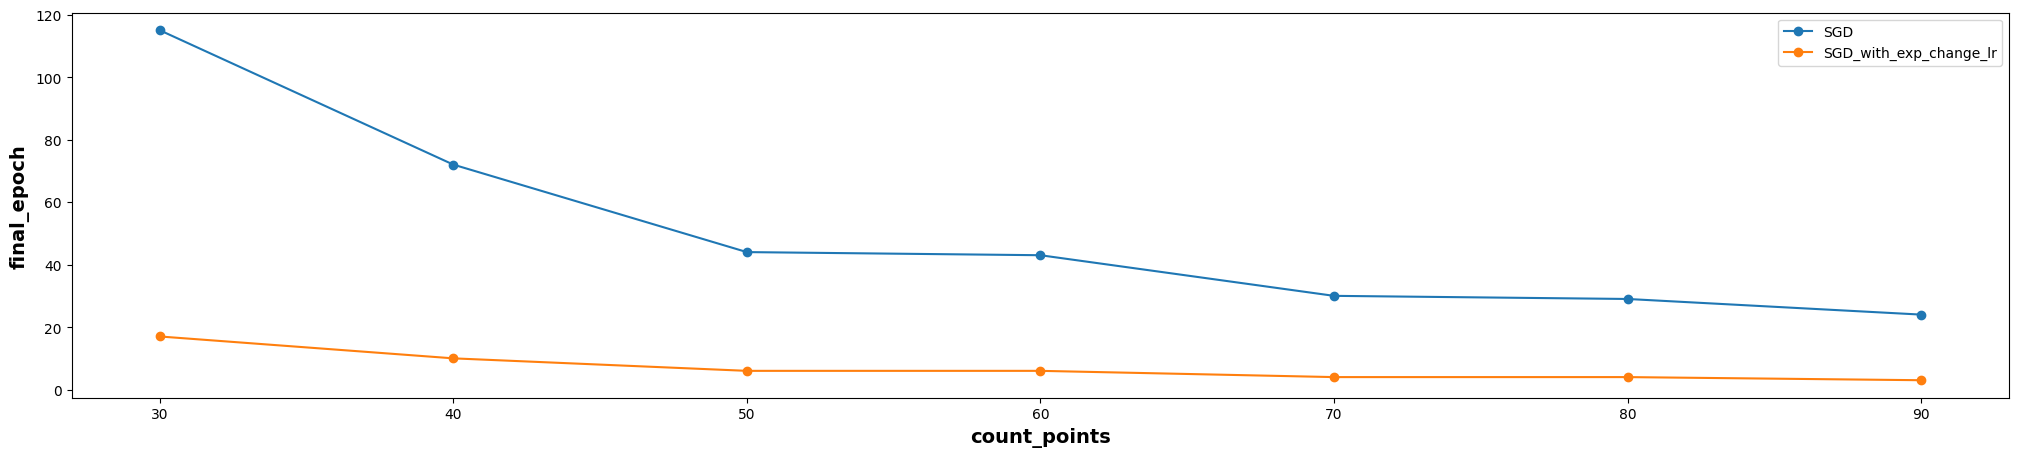

In [ ]:
count_points = range(30, 100, 10)
full_losts = [[], []]
for count in tqdm.tqdm(count_points):
  k = (np.random.random(10) * 10).tolist()
  d=0.1
  x, y, start_W = random_n_linear_regression(k, 2, count, dispx=5, disp=0.1)

  _, _, _, final_epoch = SGD(x, y, start_W, 0.001, 5000, 2, eps_stop=0.1)
  full_losts[0].append(final_epoch)

  _, _, _, final_epoch = SGD_with_exp_change_lr(x, y, start_W, 0.01, 5000, 2, exp=0.95, eps_stop=0.1)
  full_losts[1].append(final_epoch)

plt.plot(count_points, full_losts[0], '-o', label=f"SGD")
plt.plot(count_points, full_losts[1], '-o', label=f"SGD_with_exp_change_lr")
plt.legend()
plt.ylabel("final_epoch", fontsize=14, fontweight="bold")
plt.xlabel("count_points", fontsize=14, fontweight="bold")
plt.show()

####**Эксперимент 3.**

Выставим в том же эксперименте более высокую точность.

**Вывод:**

Очевидно, что модификация работает чрезвычайно нестабильно и более того - не сходится за разумное время (можно смело сказать, что расходится - т.к. после нескольких тысяч эпох коэффициент $λ$ уже слишком мал, чтобы погасить ошибку). Это можно объяснить тем, что на первых эпохах алгоритм выбрал совсем неверное направление, а далее уже не успел вернуться назад из-за сильно уменьшившийся $λ_k$. Отсюда вывод, что данному алгоритму нужна либо чрезвычайно тщательная подборка стартовой $λ$ и основания экспоненты $α$, либо он должен начинать уменьшать $λ$ с некоторой задержкой (что однако слабо поможет, ведь за первым 'плато' будет другое).

**Примечание:**

Логично, что данный метод не очень стабильный и не хоть сколько-нибудь эффективный - далее мы увидим, что для какой-либо эффективности треубется куда более сложный способ уменьшения $λ_k$ и расчета новой точки в целом.

100%|██████████| 7/7 [00:47<00:00,  6.83s/it]


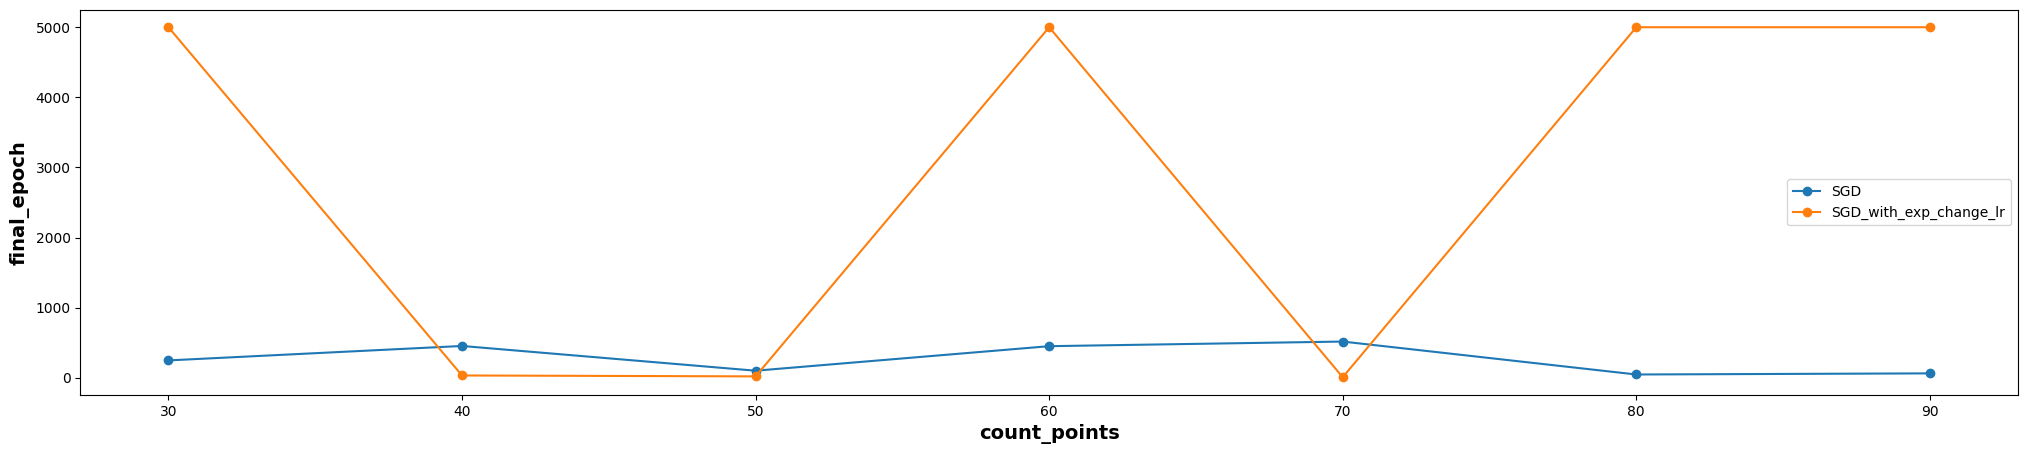

In [ ]:
count_points = range(30, 100, 10)
full_losts = [[], []]
for count in tqdm.tqdm(count_points):
  k = (np.random.random(10) * 10).tolist()
  d=0.1
  x, y, start_W = random_n_linear_regression(k, 2, count, dispx=5, disp=0.1)

  _, _, _, final_epoch = SGD(x, y, start_W, 0.001, 5000, 2, eps_stop=(((2*d)**2)/12))
  full_losts[0].append(final_epoch)

  _, _, _, final_epoch = SGD_with_exp_change_lr(x, y, start_W, 0.01, 5000, 2, exp=0.97, eps_stop=(((2*d)**2)/12))
  full_losts[1].append(final_epoch)

plt.plot(count_points, full_losts[0], '-o', label=f"SGD")
plt.plot(count_points, full_losts[1], '-o', label=f"SGD_with_exp_change_lr")
plt.legend()
plt.ylabel("final_epoch", fontsize=14, fontweight="bold")
plt.xlabel("count_points", fontsize=14, fontweight="bold")
plt.show()

###**№3) Исследование различных модификаций $SGD$**

####**Momentum (метод инерции)**

  Эта модификация служит для того, что бы быстрее находтить оптимум, а не заcтревать в локальных минимумах(выбросах). Для этого на каждом шаге мы вычисляем скользящее среднее градиента $v_k$, используя значение предыдущего градиента. Теперь мы будем вычислять в виде двух параллельных итерационных процессов $v_{k+1}=\beta_k v_k-\alpha_k \nabla H\left(x_k\right)$
  $ \quad x_{k+1}=x_k+v_{k+1}$. Как видно в новой формуле пересчетов весов, мы теперь добавляем вектор импульса, то есть учитываем предыдущие значения, чтобы коректировать значения весов. Заметим, что эта модификация играет роль регуляризации, ведь при плохо обусловленной функции направление вектора импульса будет иметь большее значени при "растянутой " координате.

  Коэффицент $beta\_1$ показывает, как много предыдущих шагов мы учитываем. Так при близком к 0 мы учитываем только предыдущий, а при 1 мы учитываем все шаги. Значение коэффицента зависит от конкретной задачи и может быть подобран.

In [ ]:
#MOMENTUM (regular)
def SGD_momentum(X, Y, W, lr, epochs = 100, batch = 1, beta_1 = 0.5, eps_stop=-1):
  change_V = lambda v, beta_1, lr, W, X_i, Y_i : beta_1 * v - lr * gradH(X_i, Y_i, W)
  change_W = lambda X_i, Y_i, W, v, g, lr : W + v
  return SGD_prototype(X, Y, W, lr, change_W, (lambda lr, epochs : lr), epochs, batch, change_V=change_V, beta_1=beta_1, eps_stop=eps_stop)

####**Nesterov Momentum (Accelerated Gradient Descent)**

Модификация стохастического градиентного спуска Nesterov, использует идею 'предпросмотра', чтобы ускорить сходимость алгоритма. В стандартном спуске, мы пересчитываем веса, используя данные для обучения, это может привести к колебаниям, особенно в напправлении низкого градиента функции потерь. Теперь к формуле пересчета модификации momentum добавилось изменение вычисления градиента, а точнее он вычисляется в точке, в которую мы бы пошли следуя импульсу.

$v_{k+1}=\beta_k v_k-\alpha_k \nabla f\left(x_k + \beta_k v_k\right)$
  $ \quad x_{k+1}=x_k+v_{k+1}$

Таким образом градиент вычисляется не только на основании текущей точки из подборки данных, а также учитывая "будущую" позицию и направление градиента.

In [ ]:
#MOMENTUM (NESTEROV)
def SGD_Nesterov_momentum(X, Y, W, lr, epochs = 100, batch = 1, beta_1 = 0.5, eps_stop=-1):
  change_V = lambda v, beta_1, lr, W, X_i, Y_i : beta_1 * v - lr * gradH(X_i, Y_i, W + beta_1 * v)
  change_W = lambda X_i, Y_i, W, v, g, lr : W + v
  return SGD_prototype(X, Y, W, lr, change_W, (lambda lr, epochs : lr), epochs, batch, change_V=change_V, beta_1=beta_1, eps_stop=eps_stop)

**Вывод:**

В двух модификациях выше мы добавили momentum к градиентному спуску и это позвляет градиентному спуску избегать локальных минимумов и искать оптимальное значение, а также ишрает роль регуляризации, ускоряя сходимость при плохой обусловленности.

####**Adagrad (Adaptive Gradient Descent)**

Adagrad (Adaptive Gradient Descent) - это алгоритм стохастического градиентного спуска, который автоматически адаптирует скорость обучения в каждый момент времени. Теперь для каждой координаты мы отдельно выбираем скорость обучения. Размер шага для определенной координаты - начальная скорость обучения, которая делится на корень из суммы квадратов градиентов координат, а также добавляется маленькое $\varepsilon$, чтобы избежать деления на 0.

$$
G_{k+1}=G_k+\left(\nabla f\left(x_k\right)\right)^2  \quad x_{k+1}=x_k-\frac{\alpha}{\sqrt{G_{k+1}+\varepsilon}} \nabla f\left(x_k\right) .
$$

Идея этой модификации в том, чтобы не допускать затухания градиента и, наоборот, не давать слишком сильно расти, чтобы не пропустить минимум. Но на практике, если шаг радикально уменьшится, то обучение сильно замедлится или может и полностью остановиться.

In [ ]:
#ADAGRAD
def SGD_AdaGrad(X, Y, W, lr, epochs = 100, batch = 1, eps_stop=-1):
  change_G = lambda v, g, beta_2, W, X_i, Y_i : g + (gradH(X_i, Y_i, W) ** 2)
  change_W = lambda X_i, Y_i, W, v, g, lr : W - (lr / np.sqrt(g + 1e-8)) * gradH(X_i, Y_i, W)
  return SGD_prototype(X, Y, W, lr, change_W, (lambda lr, epochs : lr), epochs, batch, change_G=change_G, eps_stop=eps_stop)

####**RMSProp (Root Mean Square Propagation)**

RMSProp(Root Mean Square Propagation) это модификация Adagrad, суть которой заключается в том, что мы вводим новый гиперпараметр ($\gamma$) - параметр сглаживания, который позволяет коэффициентам обновляться с определенной скоростью, в зависимости от размера градиента. Теперь мы будем не просто складывать нормы градиентов, а усреднять их в скользящем режиме.

$$
\begin{aligned}
& G_{k+1}=\gamma G_k+(1-\gamma)\left(\nabla f\left(x_k\right)\right)^2 \\
& x_{k+1}=x_k-\frac{\alpha}{\sqrt{G_{k+1}+\varepsilon}} \nabla f\left(x_k\right)
\end{aligned}
$$

 Cкорость обучения теперь учитывает среднеквадратичное отклонение градиента в прошлых шагах. Это позволяет более точно настраивать скорость обучения и избежать слишком быстрого уменьшения шага как в модификации Adagrad.

In [ ]:
def SGD_RMSProp(X, Y, W, lr, epochs = 100, batch = 1, beta_2 = 0.99, eps_stop=-1):
  change_G = lambda v, g, beta_2, W, X_i, Y_i : beta_2 * g + (1 - beta_2) * (gradH(X_i, Y_i, W) ** 2)
  change_W = lambda X_i, Y_i, W, v, g, lr : W - (lr / np.sqrt(g + 1e-8)) * gradH(X_i, Y_i, W)
  return SGD_prototype(X, Y, W, lr, change_W, (lambda lr, epochs : lr), epochs, batch, change_G=change_G, beta_2=beta_2, eps_stop=eps_stop)

**Вывод:**

Две модификации выше используют адаптивный подбор шага в зависимости от истории градиентов, тем самым адаптируются к функции потерь и выборке данных. Это позволяет замедлить шаг обучения, чтобы не пройти оптимальное значение и наоборот ускроить шаг, чтобы если мы вышли на плато по какой-то координате не застрять на нем.

####**Adam (Adaptive Moment Estimation)**

Adam (Adaptive Moment Estimation) - это модификация, которая объединяет два принципа которые мы использовали выше. Основная идея Adam заключается в использовании сочетания градиентного спуска с моментной оптимизацией параметров.

$$
\begin{aligned}
& v_{k+1}=\beta_1 v_k+\left(1-\beta_1\right) \nabla f\left(x_k\right) \\
& G_{k+1}=\beta_2 G_k+\left(1-\beta_2\right)\left(\nabla f\left(x_k\right)\right)^2 \\
& x_{k+1}=x_k-\frac{\alpha}{\sqrt{G_{k+1}+\varepsilon}} v_{k+1} .
\end{aligned}
$$

В Adam каждый параметр хранит предыдущие значения градиента и квадрата градиента. Эти значения используются для вычисления двух оценок: скользящего среднего первого момента и скользящего среднего второго момента. Т.е. достижение более быстрой сходимости требует больших объемов памяти.

In [ ]:
def SGD_Adam(X, Y, W, lr, epochs = 100, batch = 1, beta_1 = 0.9, beta_2 = 0.99, eps_stop=-1):
  change_V = lambda v, beta_1, lr, W, X_i, Y_i : beta_1 * v + (1 - beta_1) * gradH(X_i, Y_i, W)
  change_G = lambda v, g, beta_2, W, X_i, Y_i : beta_2 * g + (1 - beta_2) * (gradH(X_i, Y_i, W) ** 2)
  change_W = lambda X_i, Y_i, W, v, g, lr : W - (lr / np.sqrt(g + 1e-8)) * v
  return SGD_prototype(X, Y, W, lr, change_W, (lambda lr, epochs : lr), epochs, batch,
                       change_G=change_G, change_V=change_V, beta_1=beta_1, beta_2=beta_2, eps_stop=eps_stop)

###**№4)Исследование сходимости алгоритмов (по различным параметрам).**

In [ ]:
!pip install memory_profiler
%load_ext memory_profiler


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


100%|██████████| 7/7 [02:08<00:00, 18.38s/it]


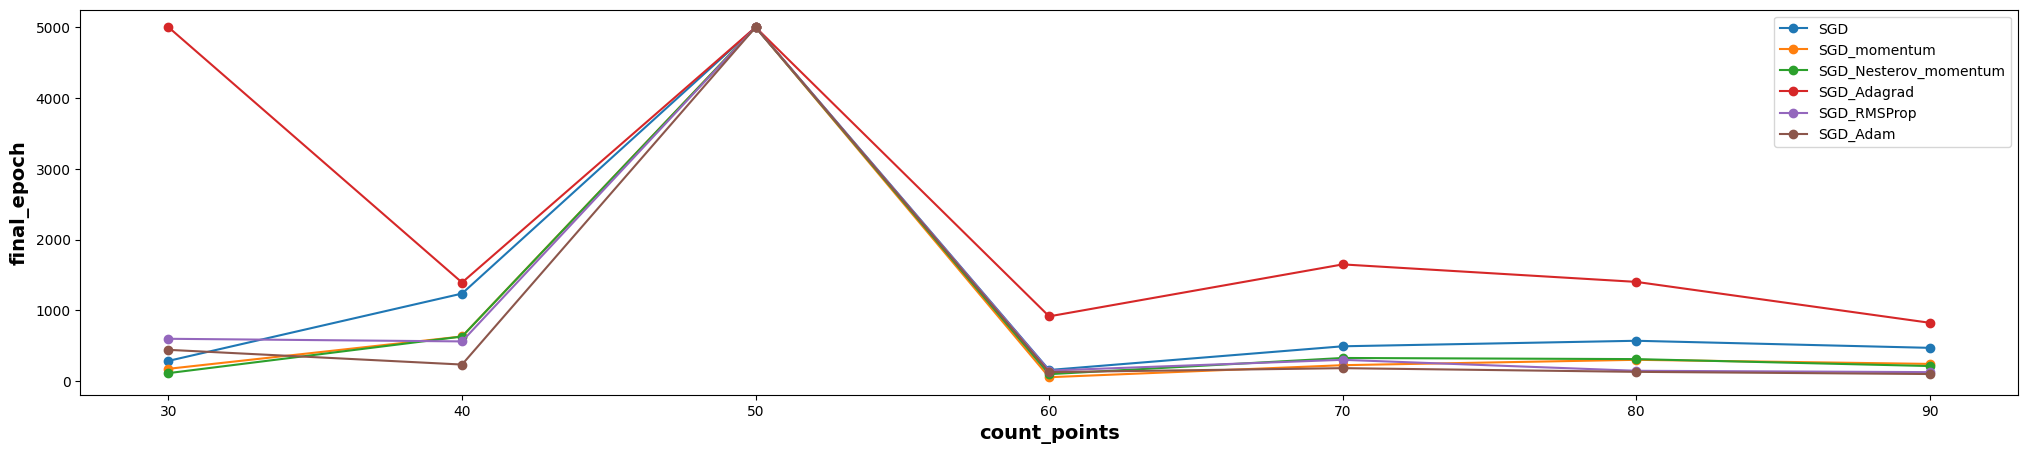

In [ ]:
#Скорость сходимости и надежность
count_points = range(30, 100, 10)
full_losts = [[], [], [], [], [], [], []]
for count in tqdm.tqdm(count_points):
  k = (np.random.random(10) * 10).tolist()
  d=0.1
  x, y, start_W = random_n_linear_regression(k, 2, count, dispx=5, disp=0.1)

  _, _, _, final_epoch = SGD(x, y, start_W, 0.001, 5000, 2, eps_stop=(((2*d)**2)/12))
  full_losts[0].append(final_epoch)

  _, _, _, final_epoch = SGD_with_exp_change_lr(x, y, start_W, 0.01, 5000, 2, eps_stop=0.1)
  full_losts[1].append(final_epoch)

  _, _, _, final_epoch = SGD_momentum(x, y, start_W, 0.001, 5000, 2, eps_stop=(((2*d)**2)/12))
  full_losts[2].append(final_epoch)

  _, _, _, final_epoch = SGD_Nesterov_momentum(x, y, start_W, 0.001, 5000, 2, eps_stop=(((2*d)**2)/12))
  full_losts[3].append(final_epoch)

  _, _, _, final_epoch = SGD_AdaGrad(x, y, start_W, 1, 5000, 2, eps_stop=(((2*d)**2)/12))
  full_losts[4].append(final_epoch)

  _, _, _, final_epoch = SGD_RMSProp(x, y, start_W, 0.01, 5000, 2, eps_stop=(((2*d)**2)/12))
  full_losts[5].append(final_epoch)

  _, _, _, final_epoch = SGD_Adam(x, y, start_W, 0.01, 5000, 2, eps_stop=(((2*d)**2)/12))
  full_losts[6].append(final_epoch)

plt.plot(count_points, full_losts[0], '-o', label=f"SGD")
# plt.plot(count_points, full_losts[1], '-o', label=f"SGD_with_exp_change_lr")
plt.plot(count_points, full_losts[2], '-o', label=f"SGD_momentum")
plt.plot(count_points, full_losts[3], '-o', label=f"SGD_Nesterov_momentum")
plt.plot(count_points, full_losts[4], '-o', label=f"SGD_Adagrad")
plt.plot(count_points, full_losts[5], '-o', label=f"SGD_RMSProp")
plt.plot(count_points, full_losts[6], '-o', label=f"SGD_Adam")
plt.legend()
plt.ylabel("final_epoch", fontsize=14, fontweight="bold")
plt.xlabel("count_points", fontsize=14, fontweight="bold")
plt.show()

  Выше приведен график, который показывает зависимость размера выборки для обучения и количества шагов которое нужно каждому методу для достижения минимума в функцие потерь с точностью $(2d)^2/12$, где $d=0.1$. Заметим, что самый лучший результат показывает Adam, что логично ведь он считается лучшим решением для задачи со стохастической оптимизацией. Почти также хорошо отработал RMSProp, а momentum модификации заметно лучше обычного SGD, но все же хуже чем Adam. Все методы кроме Adagrad с увеличением выборки начинают показывать более стабильный результат, ведь от увеличения выборки сходимость улучшается. Adagrad страдает от своей частой ошибки (а именно слишком быстрого уменьшения шага), в следствие чего ему требуется больше шагов для сходимости. Интересен так же эксперимент с размером выборки 50, на котором все алгоритмы сделали 5000 шагов, что для такой точности является очень большим значением, а значит на этих входных данных ни один алгоритм не показал хороший результат. Это говорит о ненадежности данных методов, а именно о том, что существуют данные с которыми они не справляются.

In [ ]:
# Машинные ресурсы 1.
# k = (np.random.random(10)).tolist()
x, y, start_W = random_n_linear_regression([10], 2, 1000)

print("MEM:")
%memit  SGD(x, y, start_W, 0.0001, 100, 1)

%memit SGD_with_exp_change_lr(x, y, start_W, 0.0001, 100, 1, exp=0.9)

%memit SGD_momentum(x, y, start_W, 0.0001, 100, 1)

%memit SGD_Nesterov_momentum(x, y, start_W, 0.0001, 100, 1)

%memit SGD_AdaGrad(x, y, start_W, 0.5, 100, 1)

%memit SGD_RMSProp(x, y, start_W, 0.1, 100, 1)

%memit SGD_Adam(x, y, start_W, 0.1, 100, 1)

print(":=------------------------------------------------------------------------------------------------------------------------------------")
print("TIME:")

%time  SGD(x, y, start_W, 0.0001, 100, 1)

%time SGD_with_exp_change_lr(x, y, start_W, 0.0001, 100, 1, exp=0.9)

%time SGD_momentum(x, y, start_W, 0.0001, 100, 1)

%time SGD_Nesterov_momentum(x, y, start_W, 0.0001, 100, 1)

%time SGD_AdaGrad(x, y, start_W, 0.5, 100, 1)

%time SGD_RMSProp(x, y, start_W, 0.1, 100, 1)

%time SGD_Adam(x, y, start_W, 0.1, 100, 1)


print(":=------------------------------------------------------------------------------------------------------------------------------------")
print("COUNT OPERATIONS (on time):")


MEM:
peak memory: 128.16 MiB, increment: 0.02 MiB
peak memory: 128.16 MiB, increment: 0.00 MiB
peak memory: 137.68 MiB, increment: 9.52 MiB
peak memory: 138.55 MiB, increment: 7.84 MiB
peak memory: 138.66 MiB, increment: 7.91 MiB
peak memory: 138.66 MiB, increment: 7.91 MiB
peak memory: 157.30 MiB, increment: 26.56 MiB
:=------------------------------------------------------------------------------------------------------------------------------------
TIME:
CPU times: user 3.05 s, sys: 9.85 ms, total: 3.06 s
Wall time: 3.06 s
CPU times: user 4.03 s, sys: 20.7 ms, total: 4.05 s
Wall time: 4.1 s
CPU times: user 3.54 s, sys: 14.8 ms, total: 3.55 s
Wall time: 3.57 s
CPU times: user 3.47 s, sys: 14.9 ms, total: 3.48 s
Wall time: 3.48 s
CPU times: user 6.96 s, sys: 38.8 ms, total: 7 s
Wall time: 7.04 s
CPU times: user 6.08 s, sys: 38.6 ms, total: 6.11 s
Wall time: 6.11 s
CPU times: user 7.62 s, sys: 54.7 ms, total: 7.68 s
Wall time: 7.72 s
:=--------------------------------------------------

Заметим, что все рассмотренные модификации используют примерно одно и то же количество памяти, а именно память пропорциональную количеству параметров модели. Это так, ведь каждый из алгоритмов хранит в памяти вектор ($v$ или $G$),  который имеет те же размеры, что и градиент весов модели. Единственное отличие у Adam, ведь он храниит одновременно и $v$ и $G$, а значит, использует память, пропорциональную удвоенному количеству параметров модели. Это и показывают етстовые замеры. Первые два алгоритма не хранят дополнительную информацию, из-за чего изменение в оперативной памяти почти не заметно. Алгоритмы momentum, Nesterov, Adagrad и RMSProp используют примерно один и тот же размер памяти(с учетом выбросов) для сохранения вектора размером с вектор параметров. Больше всего занимает алгоритм Adam, что логично, ведь он хранинт два массива.  

In [ ]:
# Машинные ресурсы 2.
k = (np.random.random(100) * 10).tolist()
disp=0.1
x, y, start_W = random_n_linear_regression(k, 0, 10000, dispx=5, disp=disp)
print(":=------------------------------------------------------------------------------------------------------------------------------------")
print("TIME:")
_, _, _, epoch1 = SGD(x, y, start_W, 0.001, 1000, 32, eps_stop=0.01)
print(epoch1)
%time  SGD(x, y, start_W, 0.001, 1000, 32, eps_stop=0.01)


# _, _, _, epoch2 = SGD_with_exp_change_lr(x, y, start_W, 0.0001, 1000, 32, exp=0.9, eps_stop=0.1)
# print(epoch2)
# %time SGD_with_exp_change_lr(x, y, start_W, 0.0001, 1000, 32, exp=0.9, eps_stop=0.1)


_, _, _, epoch3 = SGD_momentum(x, y, start_W, 0.001, 1000, 32, eps_stop=0.01)
print(epoch3)
%time SGD_momentum(x, y, start_W, 0.001, 1000, 32, eps_stop=0.01)


_, _, _, epoch4 = SGD_Nesterov_momentum(x, y, start_W, 0.001, 1000, 32, eps_stop=0.01)
print(epoch4)
%time SGD_Nesterov_momentum(x, y, start_W, 0.001, 1000, 32, eps_stop=0.01)


_, _, _, epoch5 = SGD_AdaGrad(x, y, start_W, 1, 1000, 32, eps_stop=0.1)
print(epoch5)
%time SGD_AdaGrad(x, y, start_W, 1, 1000, 32, eps_stop=0.1)


_, _, _, epoch6 = SGD_RMSProp(x, y, start_W, 0.001, 1000, 2, eps_stop=0.01)
print(epoch6)
%time SGD_RMSProp(x, y, start_W, 0.001, 1000, 2, eps_stop=0.01)


_, _, _, epoch7 = SGD_Adam(x, y, start_W, 0.001, 1000, 2, eps_stop=0.01)
print(epoch7)
%time SGD_Adam(x, y, start_W, 0.001, 1000, 2, eps_stop=0.01)


print()

:=------------------------------------------------------------------------------------------------------------------------------------
TIME:
196
CPU times: user 1min 25s, sys: 726 ms, total: 1min 26s
Wall time: 1min 27s
99
CPU times: user 45.3 s, sys: 811 ms, total: 46.1 s
Wall time: 45.6 s
110
CPU times: user 46.4 s, sys: 1.01 s, total: 47.5 s
Wall time: 46.7 s
67
CPU times: user 45 s, sys: 762 ms, total: 45.7 s
Wall time: 45.3 s
32
CPU times: user 27.1 s, sys: 122 ms, total: 27.3 s
Wall time: 27.3 s
29
CPU times: user 22 s, sys: 81.8 ms, total: 22.1 s
Wall time: 22.2 s



Сравним время работы наших алгоритмов. Первый замер показывает нам время работы при конкретном количестве шагов. Тоесть мы видим, как долго выполняется одна итерация. Тут можно все алгоритмы разделить на 2 группы с разницой работы в 2 раза. Как и ожидалось, алгоритмы, которые пересчитывают и сохраняют координаты градиентов - работают дольше. Но куда более интересное сравнение - это сравниение времени работы при достижении одинаковой точности. Ведь алгоритмы, которые дольше делают шаг, могут делать их меньше, из-за чего окажутся более быстрыми. Так и получается, самыми быстрыми оказались Adam и RMSProp, ведь они сошлись всего за 30 шагов. Но и среди первых трех алгоритмов появилась разница, ведь SGD без модификации делает в 2 раза больше чем momentum, из-за чего в 2 раза медленнее.

###**№5) Построение траектории спуска различных алгоритмов из одной и той же точки с одинаковой точностью.**

Проведем несколько серий экспериментов на плоскости (с более-менее оптимальными стартовыми $λ$ и выборкой в $1000$ точек):

**Серия 1 (3 эксперимента)** - есть ограничение по эпохам, старт в $[0, 0]$.

**Серия 2 (3 эксперимента)** - ограничение только по точности $\frac{(2disp)^2}{12}$, старт в $[0, 0]$.

**Серия 3 (2 эксперимента)** - один из искомых коэффициентов ответа - $0$, старт в $[0, 0]$.

**Серия 4 (2 эксперимента)** - один из искомых коэффициентов сильно больше другого, старт в $[0, 0]$.

**Серия 5 (2 эксперимента)** - старт из точки где уже найден один из коэффициентов.

###**Серия 1**

####***(ограничение и по точности, и по кол-ву эпох).***

####**Эксперимент 1.1**

$k = 10$, $b = 2$, $epochs = 100$, $batch = 1$.

ans:  [[10.001206861996254], 1.9465799797606793]
ans:  [[10.01071607397913], 1.3094754950443344]
ans:  [[10.001021805279779], 1.934750325651772]
ans:  [[10.00068846241421], 1.9819067569121571]
ans:  [[9.99214465491923], 2.5567833882842446]
ans:  [[9.99806016102224], 2.125672215734932]
ans:  [[10.000749301723088], 1.9958203004571708]


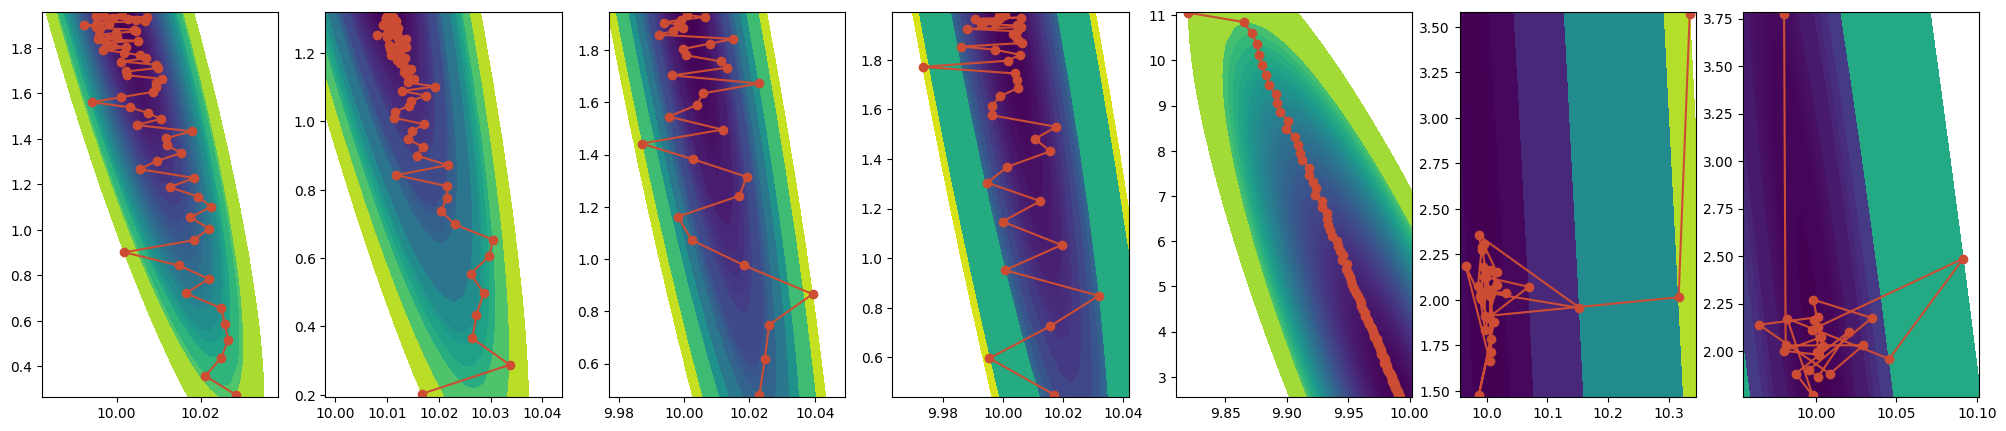

In [ ]:
# @title
#5
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2 /3
x, y, start_W = random_n_linear_regression([10], 2, 1000, disp=disp)

epochs = 100
batch = 1

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_with_exp_change_lr(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 0.5, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

####**Эксперимент 1.2**

$k = 10$, $b = 2$, $epochs = 100$, $batch = 2$.

ans:  [[10.002778041880445], 1.820317252978853]
ans:  [[10.017447673073969], 0.8519104213164469]
ans:  [[9.993607661004216], 1.9613340641147483]
ans:  [[9.999546475546193], 1.9620146168806565]
ans:  [[9.982212979932552], 3.2049836356320918]
ans:  [[9.993857039954728], 2.135783648614326]
ans:  [[9.969350625574304], 2.000371274087061]


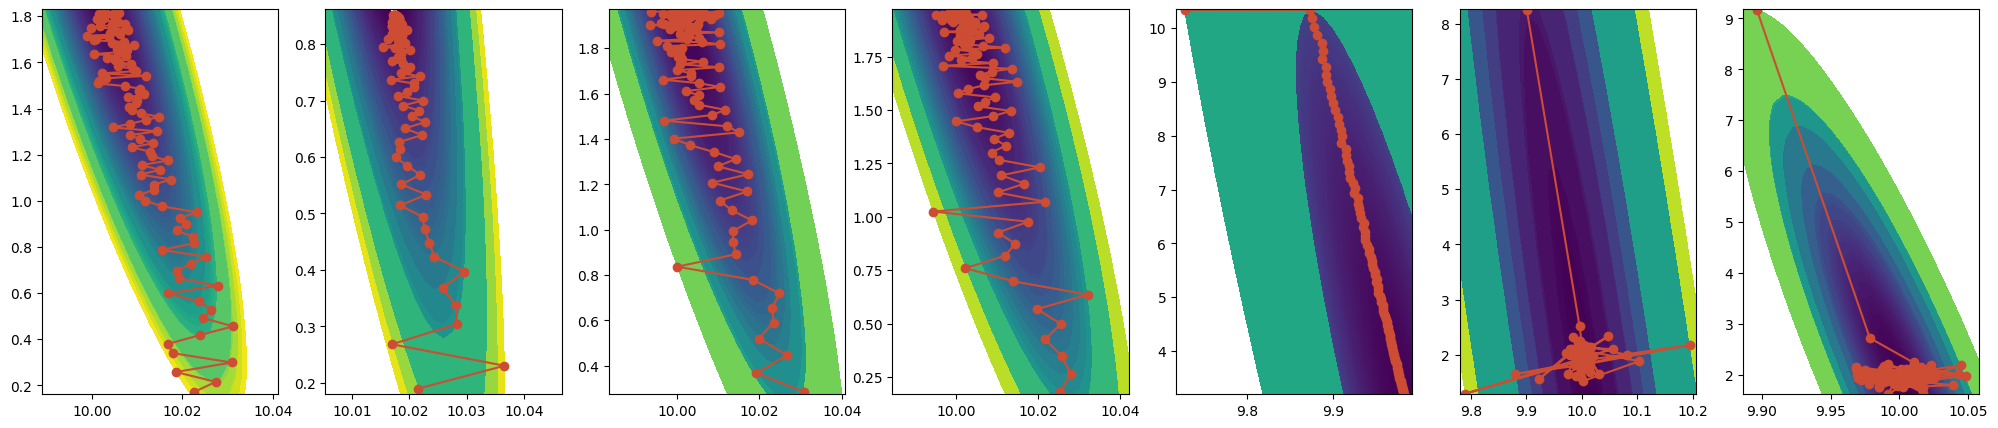

In [ ]:
# @title
#5
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2 /3
x, y, start_W = random_n_linear_regression([10], 2, 1000, disp=disp)

epochs = 100
batch = 2

# %memit SGD(x, y, start_W, 0.0001, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 500, 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_with_exp_change_lr(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 0.5, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

####**Эксперимент 1.3**

$k = 10$, $b = 2$, $batch = 10$.

ans:  [[10.017988243472077], 0.9162777245889134]
ans:  [[10.024618219682633], 0.34275326165809905]
ans:  [[10.006821714211494], 1.3505552022557967]
ans:  [[10.009845712268428], 1.3485133429772527]
ans:  [[9.915296484159567], 7.5423568914985735]
ans:  [[9.998640566620356], 2.0278384460077175]
ans:  [[10.000282549552296], 1.9857558114433804]


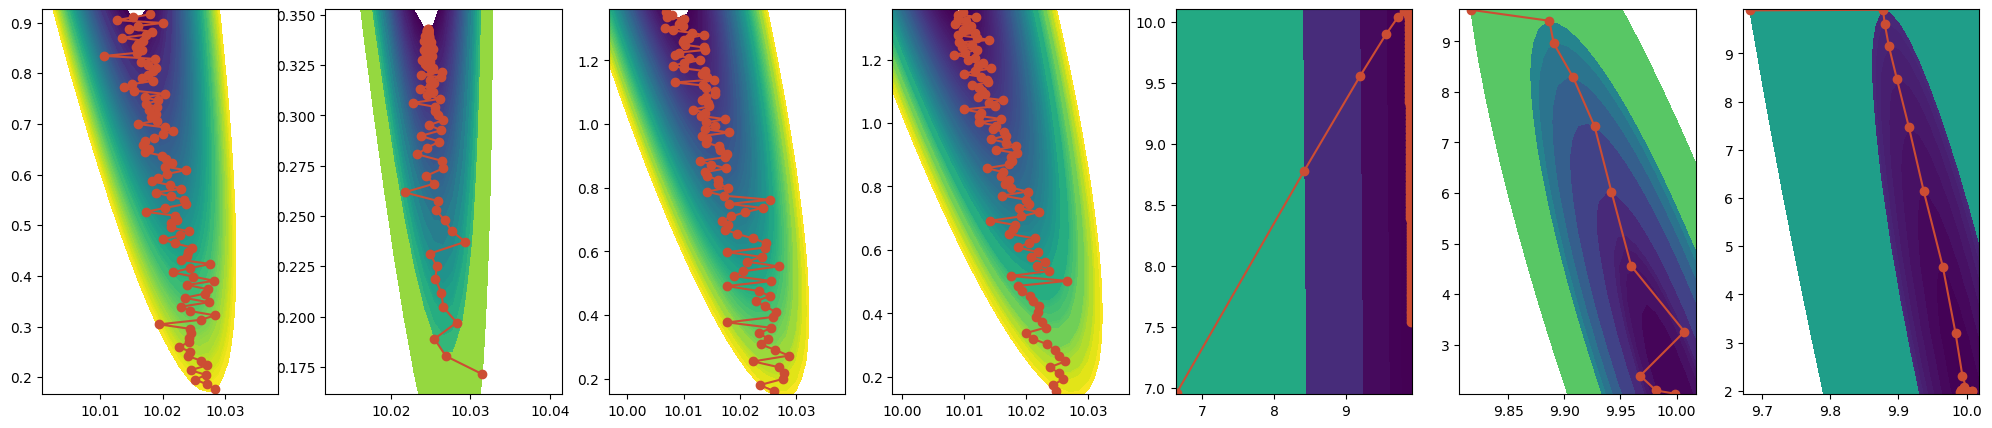

In [ ]:
# @title
#5
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2 /3
n = 1000
x, y, start_W = random_n_linear_regression([10], 2, n, disp=disp)

epochs = 100
batch = 10

# %memit SGD(x, y, start_W, 0.0001, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 500, 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_with_exp_change_lr(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 0.5, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

**Вывод:**

Цель этих экспериментов - сравнить сходимость(размер и траекторию шагов) каждой из модификации. Обычний SGD позазывает траекторию, которая сходится к минимуму, при этом часто перешагивая минимум, но всегда находит минимум. На графиках модификаций momentum можно увидеть похожий график, но при этом, шаги в "более правильном" направлении, ведь мы исследуем на функции с плохой обусловленностью, а momentum выступает в некотором роде регуляризацией, что и улучшает сходимость. График Adagrad показывает его главную проблему, а именно быстрое уменьшение шага. После первых больших шагов происходит сильное замедление, а в следствие этого алгоритм дольше идет до минимума, что показывает график с большой плотностью точек на прямой. Модификации RMSProp и Adam выбирают оптимальную траекторию и относительно быстро сходятся.

###**Серия 2**

####***(ограничение по точности без доп. зависимости между коэффицентами).***

####**Эксперимент 2.1**

$k = 10$, $b = 2$, $batch = 1$, $epsstop=\frac{(disp)^2}{12}$, $epochs=5000$.

ans:  [[10.00158068809927], 1.9274628533168416]
ans:  [[9.999987402627657], 2.003860665204593]
ans:  [[10.001323646253743], 1.9163889425112863]
ans:  [[9.99805225508907], 2.1137427502820474]
ans:  [[9.999670927375638], 2.0365875653290755]
ans:  [[10.001506501274125], 1.9109809806550995]


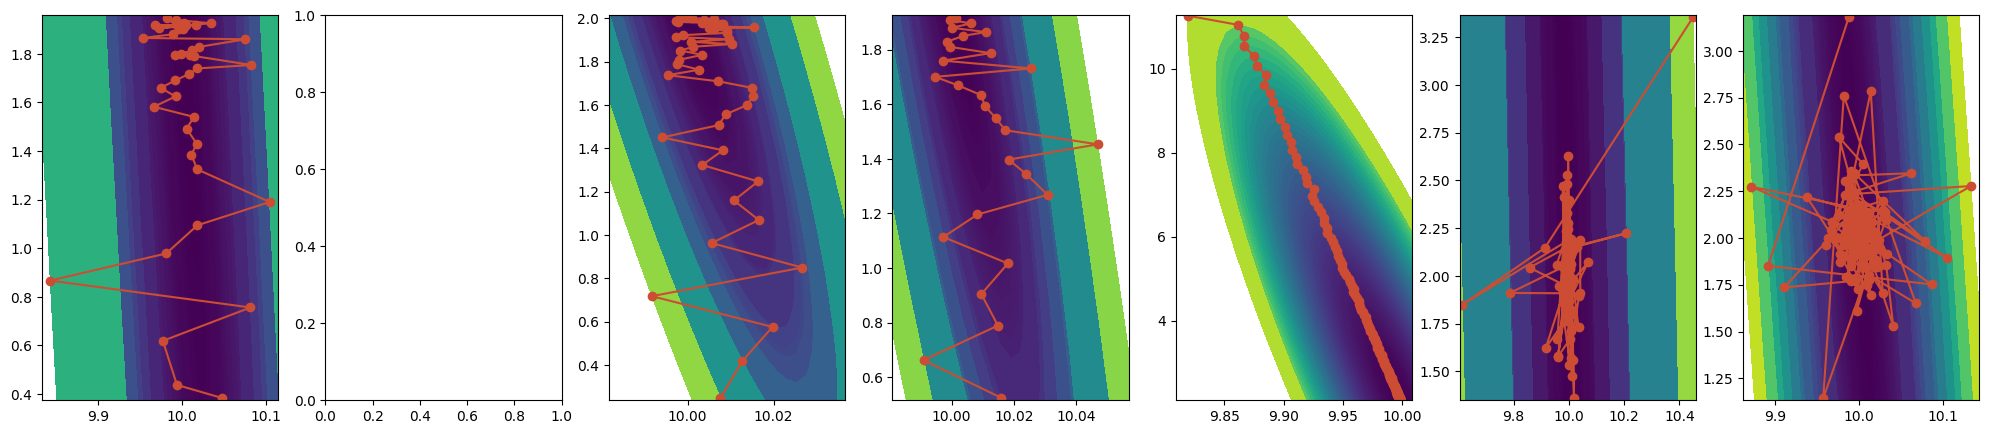

In [ ]:
# @title
#5
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2/3
n = 1000
x, y, start_W = random_n_linear_regression([10], 2, n, disp=disp)

epochs = 5000
batch = 1

# %memit SGD(x, y, start_W, 0.0001, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 500, 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.00019, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# w, points,_,_ = SGD_with_exp_change_lr(
#     x,
#     y,
#     start_W, 0.00023, epochs, batch, eps_stop=eps)

# print(np.array(points))
# print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
# print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 0.5, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

####**Эксперимент 2.2**

$k = 10$, $b = 2$, $batch = 2$, $epsstop=\frac{(disp)^2}{12}$.

ans:  [[10.000977736124064], 1.9665507033887337]
ans:  [[10.001133532099212], 1.9173009425795022]
ans:  [[10.000522215558467], 1.9516981229618031]
ans:  [[9.997411185303585], 2.157838587656242]
ans:  [[9.999507001672736], 2.02734905793917]
ans:  [[9.999222585040547], 1.9934023875850302]


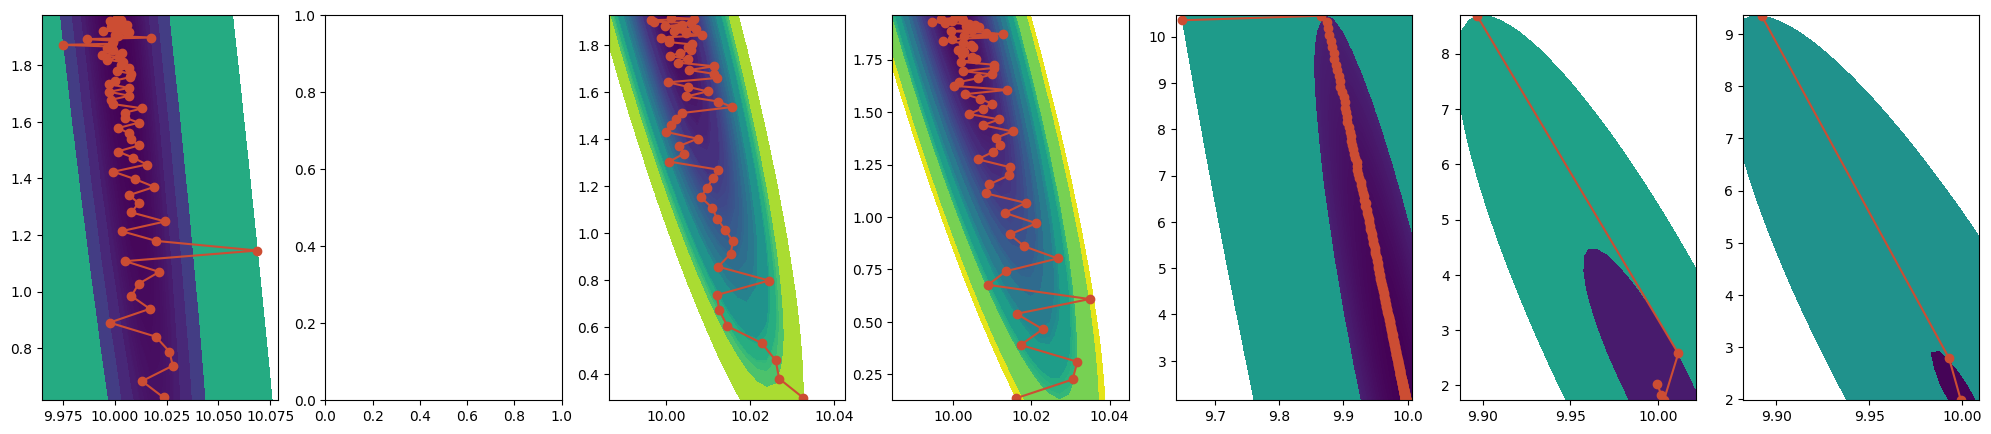

In [ ]:
# @title
#5
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2/3
n = 1000
x, y, start_W = random_n_linear_regression([10], 2, n, disp=disp)

epochs = 5000
batch = 2

# %memit SGD(x, y, start_W, 0.0001, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 500, 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.000175, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# w, points,_,_ = SGD_with_exp_change_lr(
#     x,
#     y,
#     start_W, 0.000225, epochs, batch, eps_stop=eps)

# # print(np.array(points))
# print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
# print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 0.5, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

####**Эксперимент 2.3**

$k = 10$, $b = 2$, $batch = 10$, $epsstop=\frac{(disp)^2}{12}$.

ans:  [[10.00096758420281], 1.931165483553174]
ans:  [[10.00095684644676], 1.9266701804904471]
ans:  [[10.000937500696354], 1.9204174377421808]
ans:  [[9.99743523414728], 2.146152731678339]
ans:  [[9.99852836019094], 2.0113736711990846]
ans:  [[9.9981009670711], 2.0383589192738922]


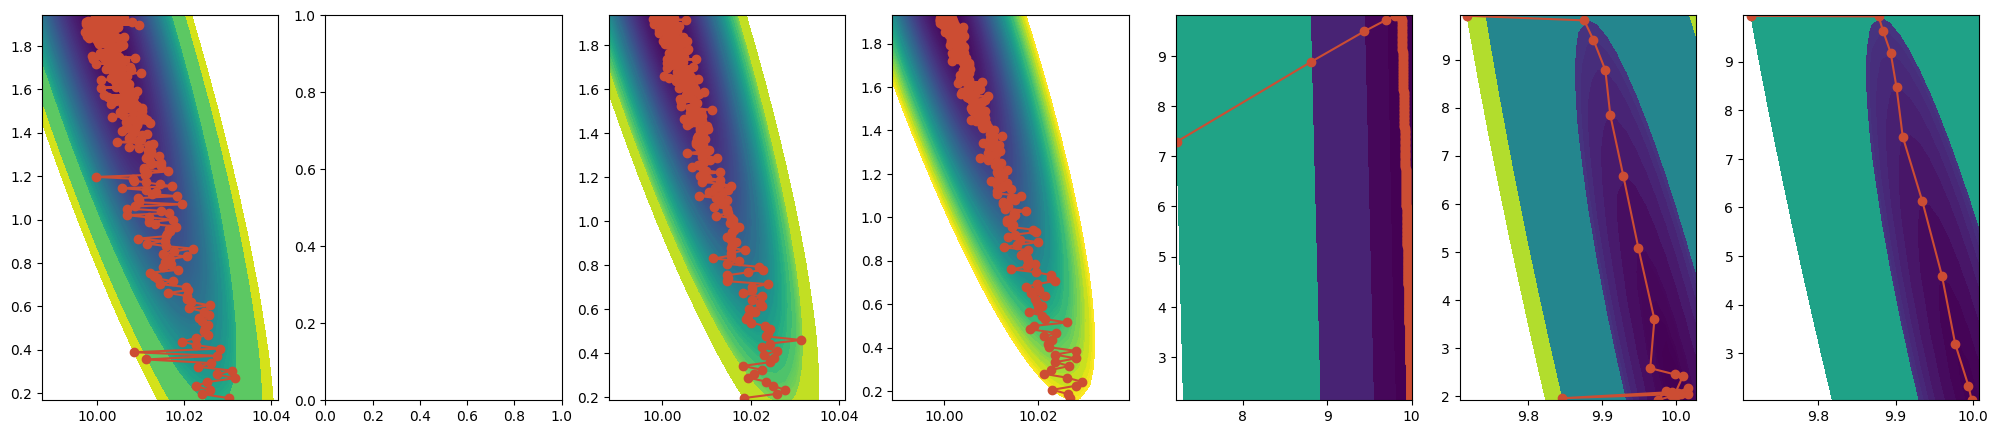

In [ ]:
# @title
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2/3
n = 1000
x, y, start_W = random_n_linear_regression([10], 2, n, disp=disp)

epochs = 5000
batch = 10

# %memit SGD(x, y, start_W, 0.0001, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 500, 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.000195, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# w, points,_,_ = SGD_with_exp_change_lr(
#     x,
#     y,
#     start_W, 0.000225, epochs, batch, eps_stop=eps)

# # print(np.array(points))
# print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
# print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 0.5, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

**Вывод:**

Cерия экспериментов показывает нам те же алгоритмы, но их траектоирия не по числу шагов, а до определенной точности. Эти графики не показывают ничего нового, ведь это те же самые траектории, только, с большим числом шагов. Но можно заметить, что шаги Adagrad все меньше, а последние два алгоритма быстро сходятся и не используют все предоставленные шаги.

###**Серия 3**

####***Один из искомых коэффициентов - $0$***

####**Эксперимент 3.1**

$k = 10$, $b = 0$, $batch = 10$, $epsstop=\frac{(disp)^2}{12}$.

ans:  [[9.998966575981816], 0.06053165630165561]
ans:  [[9.999057316438314], 0.05869505086305204]
ans:  [[9.998987870933894], 0.0605786896643606]
ans:  [[9.998979079936719], 0.06142982549339698]
ans:  [[9.999672015735799], 0.02598732762096374]
ans:  [[9.999320638899052], 0.052809285591863785]


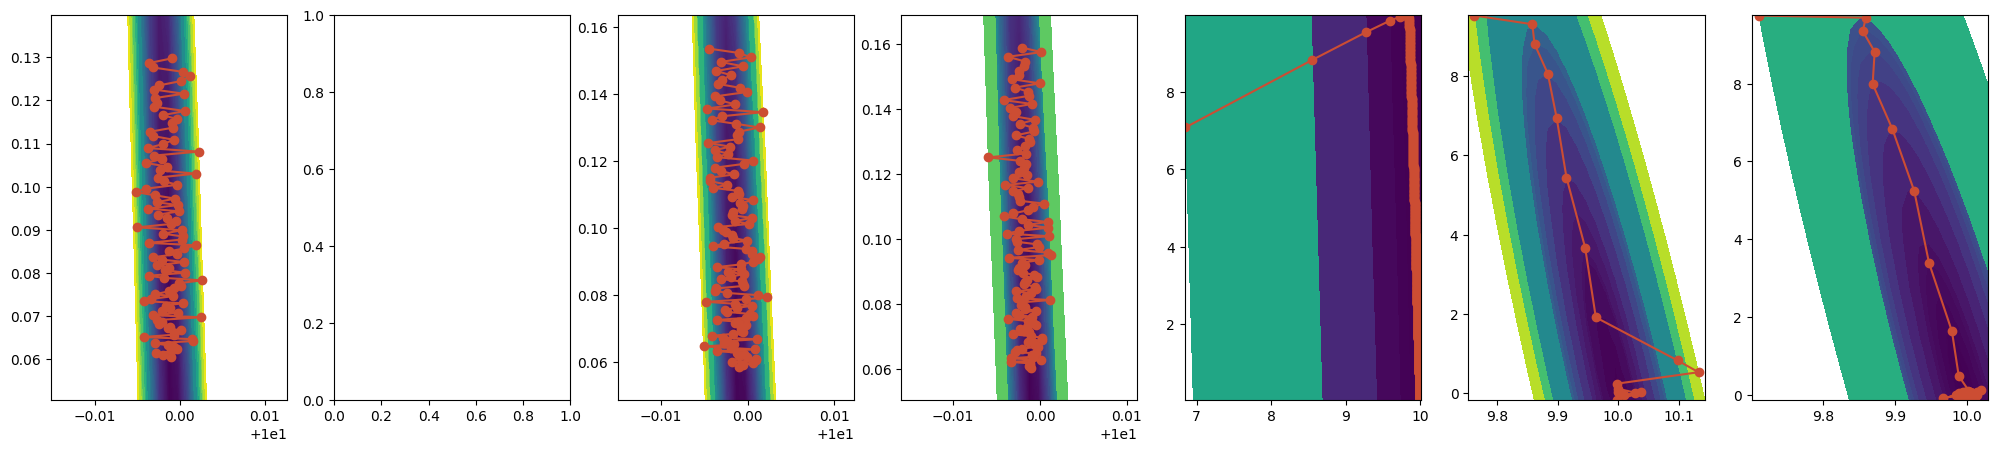

In [ ]:
# @title
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2/3
n = 1000
x, y, start_W = random_n_linear_regression([10], 0, n, disp=disp)

epochs = 5000
batch = 10

# %memit SGD(x, y, start_W, 0.0001, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 500, 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.00019, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# w, points,_,_ = SGD_with_exp_change_lr(
#     x,
#     y,
#     start_W, 0.000225, epochs, batch, eps_stop=eps)

# # print(np.array(points))
# print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
# print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 0.5, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

####**Эксперимент 3.2**

$k = 0$, $b = 2$, $batch = 10$, $epsstop=\frac{(disp)^2}{12}$.

ans:  [[0.0010166645670544037], 1.9385828091535364]
ans:  [[0.0010820985348066476], 1.9328785690804147]
ans:  [[0.0010076618409549873], 1.9364150248605265]
ans:  [[0.00015558850584449787], 1.9520974285895354]
ans:  [[0.0009004439897053224], 1.946269257729095]
ans:  [[5.9282078807556746e-05], 1.9730242360998722]


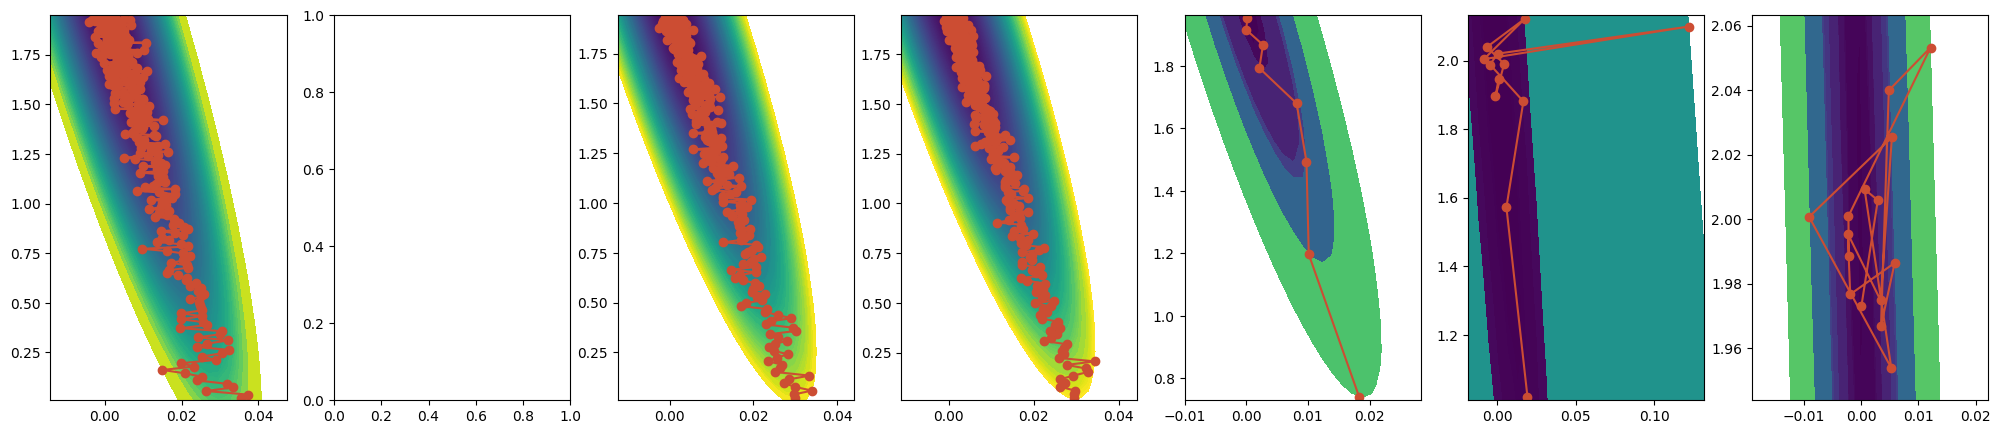

In [ ]:
# @title
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2/3
n = 1000
x, y, start_W = random_n_linear_regression([0], 2, n, disp=disp)

epochs = 5000
batch = 10

# %memit SGD(x, y, start_W, 0.0001, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 500, 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.00019, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# w, points,_,_ = SGD_with_exp_change_lr(
#     x,
#     y,
#     start_W, 0.00023, epochs, batch, eps_stop=eps)

# # print(np.array(points))
# print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
# print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 0.5, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

**Вывод:**

Эти эксперименты демонстрируют работу алгоритма при 0 кэффиценте(одном из двух) уравнения прямой. Траектории всех алгоритмов получаются более сжатыми по одной из координат, ведь она не влияет на функцию потерь. При одной ненулевой координате приемущества momentum перед обычным спуском теряются, из-за чего эти 3 графика почти идентичны.  

###**Серия 4**

####***Один из искомых коэффициентов на порядки больше другого.***

####**Эксперимент 4.1**

$k = 10000$, $b = 2$, $batch = 10$, $epsstop=\frac{(disp)^2}{12}$.

ans:  [[9999.99837900438], 2.1019960782105]
ans:  [[9999.998285669788], 2.1009117212631696]
ans:  [[9999.99850101919], 2.097317540333101]
ans:  [[9938.097895784083], 4088.59798990508]
ans:  [[9998.520798982501], 67.56061350847014]
ans:  [[10000.000515025136], 1.9944393017930946]


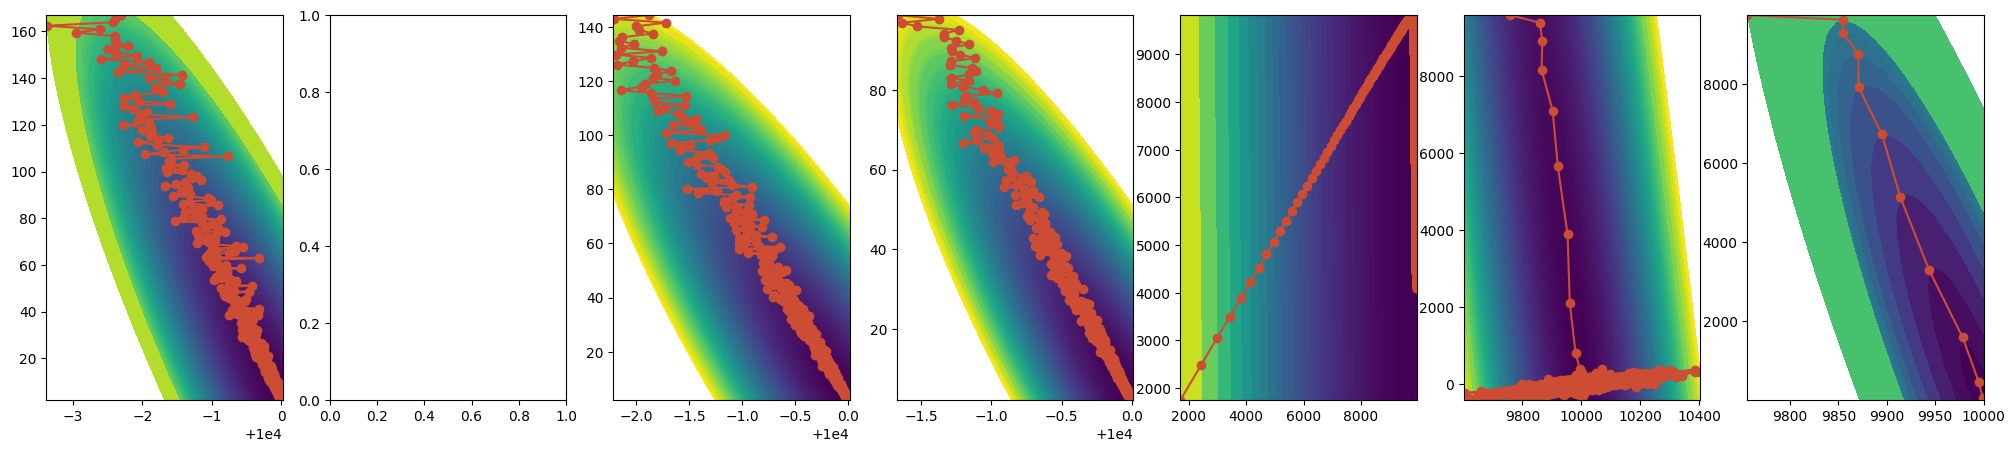

In [ ]:
# @title
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2/3
n = 1000
x, y, start_W = random_n_linear_regression([10_000], 2, n, disp=disp)

epochs = 5000
batch = 10

# %memit SGD(x, y, start_W, 0.0001, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 500, 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.00019, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# w, points,_,_ = SGD_with_exp_change_lr(
#     x,
#     y,
#     start_W, 0.000225, epochs, batch, eps_stop=eps)

# # print(np.array(points))
# print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
# print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 100, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 100, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 100, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

####**Эксперимент 4.2**

$k = 10$, $b = 1000$, $batch = 10$, $epsstop=\frac{(disp)^2}{12}$.

ans:  [[10.00185774704287], 999.8734964755108]
ans:  [[10.00213698325055], 999.8666153470289]
ans:  [[10.00237979091803], 999.8707730279951]
ans:  [[12.380951965164392], 844.7077774342076]
ans:  [[10.00022156005099], 1000.0183688201431]
ans:  [[10.001998946475346], 999.9219311504191]


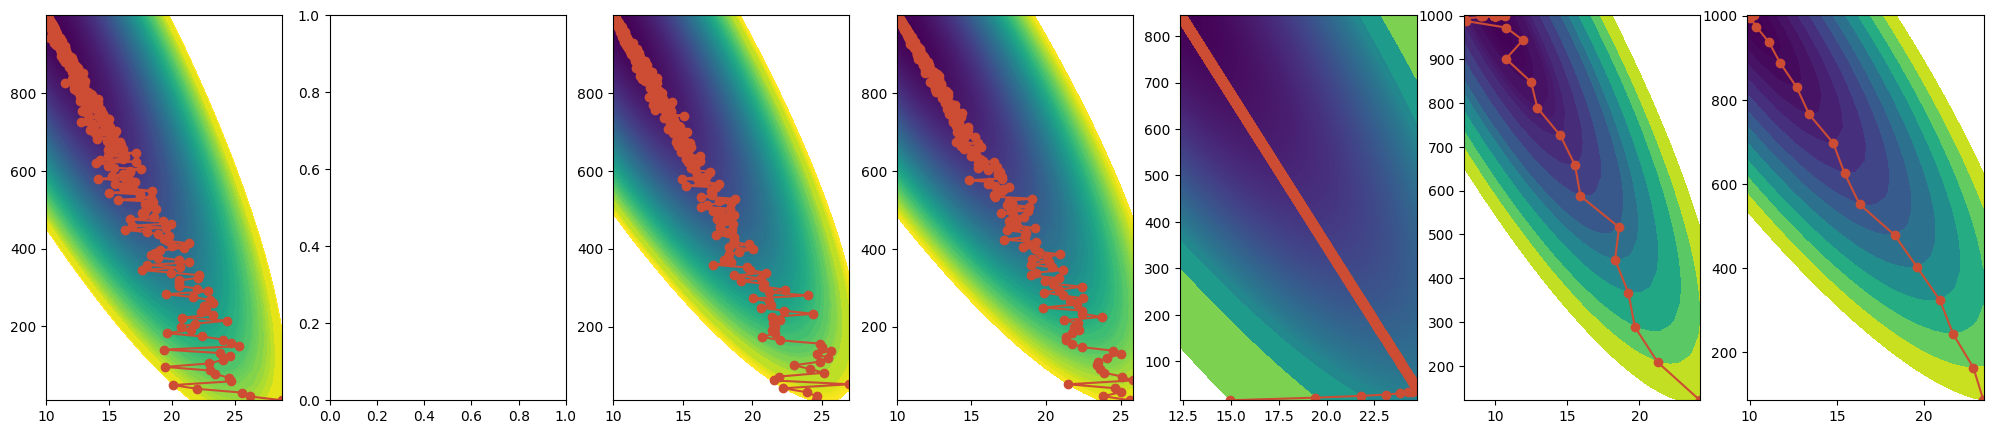

In [ ]:
# @title
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2/3
n = 1000
x, y, start_W = random_n_linear_regression([10], 1_000, n, disp=disp)

epochs = 5000
batch = 10

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.00019, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# w, points,_,_ = SGD_with_exp_change_lr(
#     x,
#     y,
#     start_W, 0.000225, epochs, batch, eps_stop=eps)

# # print(np.array(points))
# print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
# print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

**Вывод:**

Эти эксперименты позволяют оценить сходимость алгоритмов при очень большом коэффиценте искомой функции. Как и в прошлом работа первых трех алгоритмов совпадает, Adagrad слишком быстро уменьшает шаг, а с последнимим двумя уже интереснее. Относительно хорошее приблежения оба алгоритма находят быстро, но дальше в Adam играет роль уиеньшение шага, благодаря чему он не делает таких сильных скачков через минимум как RMSProp.

###**Серия 5**

####***Один из искомых найден при старте алгоритма (оптимизация идет только по одному)***

####**Эксперимент 5.1**

$k = 10$, $b = 2$, $batch = 10$, $epsstop=\frac{(disp)^2}{12}$, $W=[10, 0]$.

ans:  [[9.999719176284673], 2.02011786052044]
ans:  [[9.999727536752655], 2.0190163762877895]
ans:  [[9.999599923945322], 2.0224254007686677]
ans:  [[9.999528284957115], 2.027418941331569]
ans:  [[9.999424233419054], 2.0311242001641454]
ans:  [[9.999191934400448], 2.049857884953378]


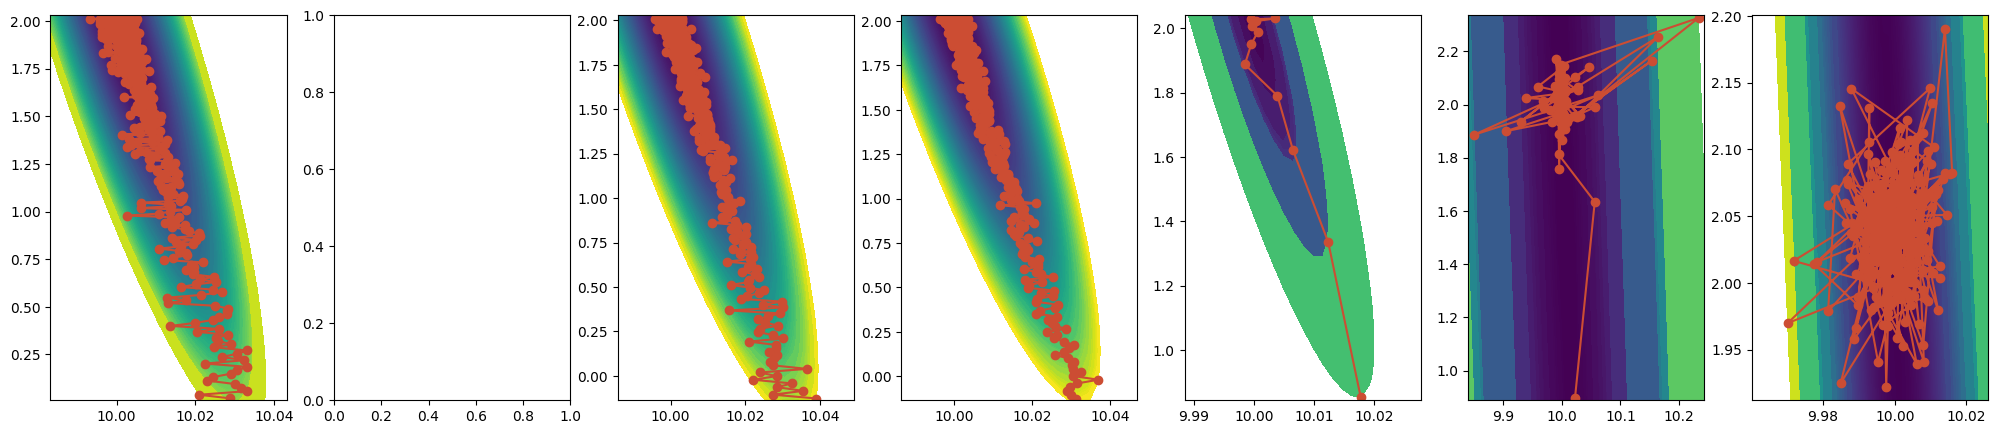

In [ ]:
# @title
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2/3
n = 1000
x, y, start_W = random_n_linear_regression([10], 2, n, disp=disp)
start_W[0] = 10

epochs = 5000
batch = 10

# %memit SGD(x, y, start_W, 0.0001, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 500, 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.00019, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# w, points,_,_ = SGD_with_exp_change_lr(
#     x,
#     y,
#     start_W, 0.000225, epochs, batch, eps_stop=eps)

# # print(np.array(points))
# print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
# print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 0.5, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

####**Эксперимент 5.2**

$k = 10$, $b = 2$, $batch = 10$, $epsstop=\frac{(disp)^2}{12}$, $W=[0, 2]$.

ans:  [[9.998298163132693], 2.096387413270726]
ans:  [[9.998143004515482], 2.097806147933735]
ans:  [[9.998130252971956], 2.0942353663648237]
ans:  [[9.998185062367707], 2.099063132419277]
ans:  [[9.999359458827305], 2.025643730625117]
ans:  [[9.999384348332718], 2.0601852946088433]


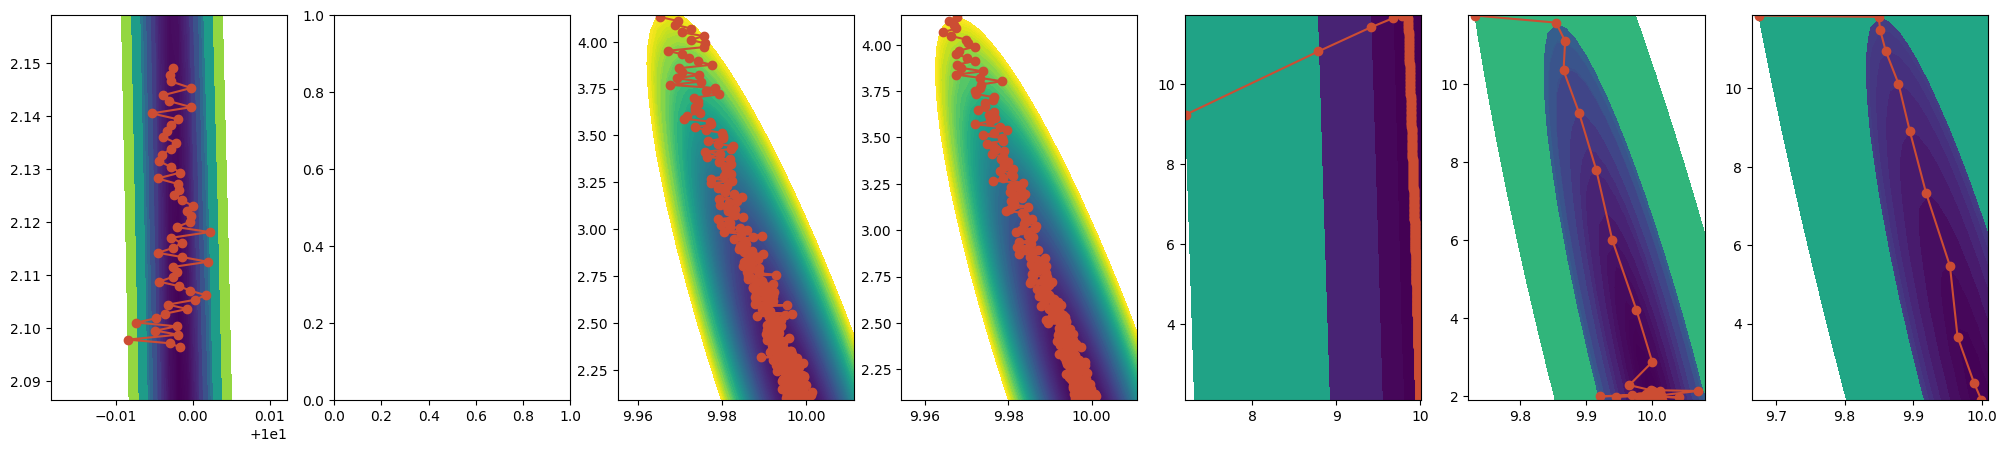

In [ ]:
# @title
# %%time
plt.rcParams["figure.figsize"] = (25, 5)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6, ax7)) = plt.subplots(1, 7)

disp=0.5
eps= disp**2/3
n = 1000
x, y, start_W = random_n_linear_regression([10], 2, n, disp=disp)
start_W[1] = 2

epochs = 5000
batch = 10

# %memit SGD(x, y, start_W, 0.0001, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 50, 1)
# %memit SGD_Adam(x,y,start_W, 0.1, 500, 1)

# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD(
    x,
    y,
    start_W, 0.00018, epochs, batch, eps_stop=eps)

# print(np.array(points))
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax1)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# w, points,_,_ = SGD_with_exp_change_lr(
#     x,
#     y,
#     start_W, 0.000225, epochs, batch, eps_stop=eps)

# # print(np.array(points))
# print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax2)
# print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax3)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Nesterov_momentum(
    x,
    y,
    start_W, 0.0001, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax4)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

w, points,_,_ = SGD_AdaGrad(
    x,
    y,
    start_W, 0.5, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax5)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_RMSProp(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax6)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
w, points,_,_ = SGD_Adam(
    x,
    y,
    start_W, 0.1, epochs, batch, eps_stop=eps)

# print(points)
print_gradient_work(np.array(points), lambda W: H_paint_2(x, y, W), custom_plt=ax7)
print("ans: ", w)
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

**Вывод:**

Эта серия покажет нам как алгоритмы справятся, если один коэффицент уже найден. Данная серия очень похожа на 3, что и следовало ожидать, ведь  функция потерь теперь почти не зависит от известного коэффицента(тоесть он на нее не влияет). Получается при одной известной координате все методы ищут только неизвестную со скоростью как при обычном поиске.

#**ДОП**

###**№6) Полиномиальная регрессия (и SGD решающий ее).**

Полиномиальная регрессия - это регрессия, где ф-ция $f$ - является полиномом $n$-ной степени, а не $1$-ой (если возвращаться к пункту 1 и описанию линейной регрессии)

Более формально, полиномиальная регрессия - это некоторая последовательость пар $(x_i, y_i)$, задающих с какой-то дисперсией функцию $f$ вида $f(x)=\sum_{i=1}^n{w_i^Tx^i}+b$, где $x,w_i \in R^n$, $y_i \in R$, то есть $x-n$-мерная точка, а $y_i=f(x_i)+ϵ_i$.

Все остальное определяется и устроено ровно также, как при линейной регрессии (в пункте 1 это изложено более-менее в общем виде).



In [ ]:
def L_mse(X, Y, W):
  n = X.shape[0]
  ans = []
  z = np.zeros(W.shape[1])
  z[-1] = 1

  x_deg = np.vander(X, N=n+1).T
  error = np.ones(n) @ (W[:-1] * x_deg[:-1]) @ np.ones(n) + W[-1][-1] - Y
  return error ** 2

def regularization(W, al_1, al_2):
  if (al_1 == 0 and al_2 == 0):
    return 0
  return al_1 * np.sum(np.abs(W)) + al_2 * np.sum(W ** 2)

def H_mse(X, Y, W, al_1, al_2):
  sum = 0
  m = Y.shape[0]
  for i in range(Y.shape[0]):
    sum += L_mse(X[i], Y[i], W)
  return 1/m * sum + regularization(W, al_1, al_2)


def d_regularization(W, al_1, al_2):
  if (al_1 == 0 and al_2 == 0):
    return 0
  return al_1 * np.maximum(1 - W, 0) + al_2 * (2 * W)

def gradH_polynomial(X, Y, W, grL, al_1, al_2):
  sum = [np.zeros(W.shape[1]) for i in range(W.shape[0])]
  m = Y.shape[0]
  for i in range(Y.shape[0]):
    sum += grL(X[i], Y[i], W)
  return 1/m * sum + d_regularization(W, al_1, al_2)

def SGD_polynomial_prototype(X, Y, W, lr, grL, epochs, batch, al_1=0, al_2=0, eps_stop=-1):
  cur_epoch = 0
  n = len(X)
  while (cur_epoch <= epochs and (eps_stop == -1 or H_mse(X, Y, W, al_1, al_2) > eps_stop)):
    cur_epoch+=1
    rand_permut = np.random.permutation(n)
    X_s = X[rand_permut]
    Y_s = Y[rand_permut]
    for i in range(0, n, batch):
      X_i = X_s[i:i+batch]
      Y_i = Y_s[i:i+batch]
      W = W - lr * gradH_polynomial(X_i, Y_i, W, grL, al_1, al_2)
  return W, cur_epoch

Опять же выбираем $MSE$ в качестве ф-ции потерь для одного эл-та, хотя код вполне расширяем и метод может принимать на вход любую корректную ф-цию потерь.

In [ ]:
def mse_grL(X, Y, W):
    n = X.shape[0]
    ans = []
    z = np.zeros(W.shape[1])
    z[-1] = 1

    x_deg = np.vander(X, N=n+1).T
    error = np.ones(n) @ (W[:-1] * x_deg[:-1]) @ np.ones(n) + W[-1][-1] - Y
    for i in range(W.shape[0] - 1):
      ans.append(2 * error * x_deg[i])
    ans.append(2 * error * z)
    return np.array(ans)
def SGD_polynomial_MSE(X, Y, W, lr, epochs=100, batch=1, eps_stop=-1):
  return SGD_polynomial_prototype(X, Y, W, lr, mse_grL, epochs, batch, eps_stop=eps_stop)

In [ ]:
#

print(SGD_polynomial_MSE(np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8]]),
          np.array([[3], [8], [15], [24], [35], [48], [63], [80]]),
           np.array([[0, 0], [0, 0], [0, 0]]), 0.0001, 1000, 1))
print(SGD_polynomial_MSE(np.array([[1], [2], [3], [4], [5], [6], [7], [8]]),
          np.array([[1], [2], [3], [4], [5], [6], [7], [8]]),
           np.array([[0], [0]]), 0.0001, 100, 1))

(array([[0.50831148, 0.50831148],
       [0.91419286, 0.91419286],
       [0.        , 0.36333496]]), 1001)
(array([[0.95678022],
       [0.16438519]]), 101)


###**№6.1) Построение графиков восстановленной регрессии для полиномов разной степени.**

Для лучшей демонстрации реализуем ф-цию генерации соответствующих полиномиальных задач на плоскости. Она будет принимать коэффиценты полинома $f(x)=W_n^Tx^n + … + W_1^Tx + β$ и генерировать некоторое кол-во $(count)$ пар $(x_i, f(x_i) + ϵ_i)$, где $ϵ_i-$ случайная прибавка соответствующая нормальному распределению $[-disp, disp]$.



In [ ]:
def generate_N_polynomial_task_in_R2(coefficients, count, dispx=10, disp=0.1):
  n=len(coefficients)-1
  X = []
  real_X = []
  for i in range(count):
    r = np.random.rand() * dispx
    real_X.append(r)
    point_x = []
    point_x.append(r)
    for j in range(n-1):
      point_x.append(0)
    X.append(point_x)
  y = []
  for i in range(count):
    sum = 0
    x = 1
    for j in range(n, -1, -1):
      sum += x * coefficients[j]
      x *= real_X[i]
    y.append([sum + np.random.uniform(-disp, disp)])
  return np.array(X), np.array(y), np.array([[0 for i in range(n)] for i in range(n+1)])


Также реализуем отрисовку полинома по его коэффицентам.

In [ ]:
def polynom_f(W, x):
  sum = 0
  xn = 1
  for i in range(len(W)-1, -1, -1):
    sum += W[i] * xn
    xn *= x
  return sum

def print_func_in_R2(W, name="", dist=100, num=25, custom_plt=plt):
  w = []
  for i in range(W.shape[0]):
    w.append(W[i][0])

  x = np.linspace(-dist, dist, num)
  g = lambda x : polynom_f(w, x)
  custom_plt.plot(x, g(x), '-o', label=f"{name}")

f1 = x^2
f2 = x^3
f3 = -x^3 + 5x^2
f4 = x^4
f5 = 0.01*x^7
f6 = -0.001*x^8
f7 = -10*x^2 + 10
f8 = 5x + 5
f9 = 0.01x^5 + 10x^4 - 20x^3 - 2x
f10 = x^2 -2x + 1
f11 = x^3 -3x^2 + 2x
f12 = 0.5x^4 - x^3 + 2x^2 - 5x + 1


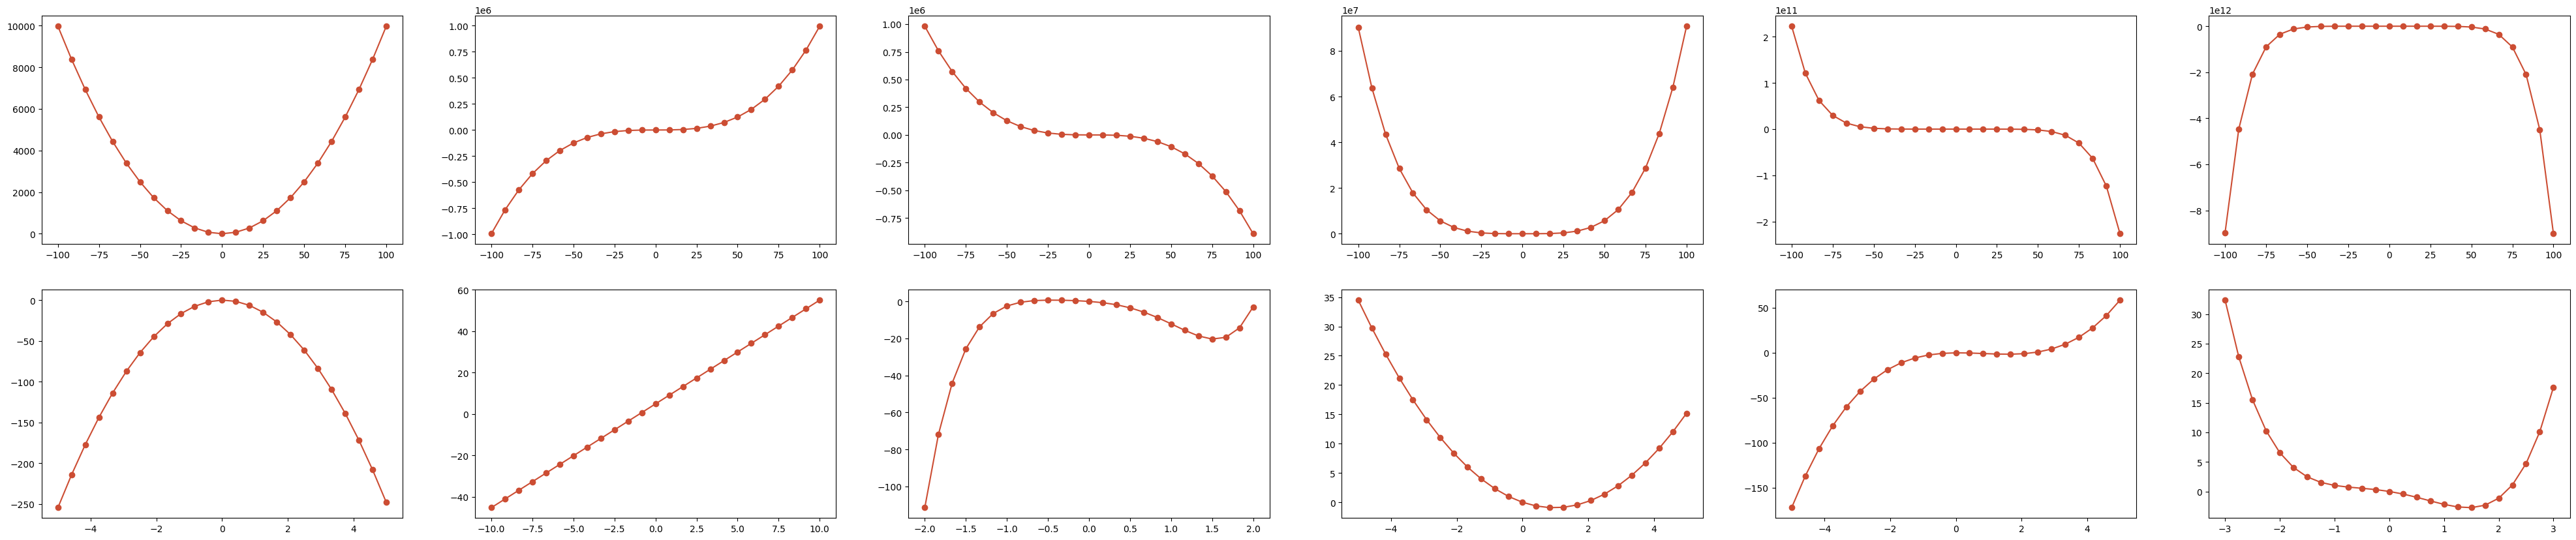

In [ ]:
#@title
plt.rcParams["figure.figsize"] = (50, 10)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6),
      (ax7, ax8, ax9, ax10, ax11, ax12)) = plt.subplots(2, 6)

print("f1 = x^2")
X, Y, start_W = generate_N_polynomial_task_in_R2([1, 0, 0], 100, dispx=5, disp=0.1)
W = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 1000, 1)
print_func_in_R2(W, name="x^2", custom_plt=ax1)

print("f2 = x^3")
X, Y, start_W = generate_N_polynomial_task_in_R2([1, 0, 0, 0], 100, dispx=5, disp=0.1)
W = SGD_polynomial_MSE(X, Y, start_W, 0.00001, 1000, 1)
print_func_in_R2(W, "x^3", custom_plt=ax2)

print("f3 = -x^3 + 5x^2")
X, Y, start_W = generate_N_polynomial_task_in_R2([-1, 5, 0, 0], 100, dispx=5, disp=0.1)
W = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 1000, 1)
print_func_in_R2(W, "-x^3", custom_plt=ax3)

print("f4 = x^4")
X, Y, start_W = generate_N_polynomial_task_in_R2([1, 0, 0, 0, 0], 100, dispx=2, disp=0.1)
W = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 1000, 1)
print_func_in_R2(W, "x^4", custom_plt=ax4)

print("f5 = 0.01*x^7")
X, Y, start_W = generate_N_polynomial_task_in_R2([0.01, 0, 0, 0, 0, 0, 0, 0], 100, dispx=1, disp=0.1)
W = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 1000, 1)
print_func_in_R2(W, "x^7", custom_plt=ax5)


print("f6 = -0.001*x^8")
X, Y, start_W = generate_N_polynomial_task_in_R2([-0.001, 0, 0, 0, 0, 0, 0, 0, 0], 100, dispx=2, disp=0.01)
W = SGD_polynomial_MSE(X, Y, start_W, 0.000001, 1000, 1)
print_func_in_R2(W, "x^8", custom_plt=ax6)

print("f7 = -10*x^2 + 10")
X, Y, start_W = generate_N_polynomial_task_in_R2([-10, 0, 10], 100, dispx=10, disp=0.1)
W = SGD_polynomial_MSE(X, Y, start_W, 0.00001, 10000, 1)
print_func_in_R2(W, "-10x^2 + 10", dist=5, custom_plt=ax7)


print("f8 = 5x + 5")
X, Y, start_W = generate_N_polynomial_task_in_R2([5, 5], 100, dispx=10, disp=0.1)
W = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 1000, 1)
print_func_in_R2(W, "5x + 5", dist=10, custom_plt=ax8)

print("f9 = 0.01x^5 + 10x^4 - 20x^3 - 2x")
X, Y, start_W = generate_N_polynomial_task_in_R2([0.01, 10, -20, 0, -2, 0], 100, dispx=2, disp=0.1)
W = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 5000, 1)
print_func_in_R2(W, "0.01x^5 + 10x^4 - 20x^3 - 2x", dist=2, custom_plt=ax9)

print("f10 = x^2 -2x + 1")
X, Y, start_W = generate_N_polynomial_task_in_R2([1, -2, 1], 100, dispx=10, disp=0.01)
W = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 1000, 1)
print_func_in_R2(W, "f10 =  x^2 -2x + 1", dist=5, custom_plt=ax10)

print("f11 = x^3 -3x^2 + 2x")
X, Y, start_W = generate_N_polynomial_task_in_R2([1, -3, 2, 0], 100, dispx=5, disp=0.01)
W = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 1000, 1)
print_func_in_R2(W, "f11 = x^3 -3x^2 + 2x", dist=5, custom_plt=ax11)


print("f12 = 0.5x^4 - x^3 + 2x^2 - 5x + 1")
X, Y, start_W = generate_N_polynomial_task_in_R2([0.5, -1, 2, -5, 1], 100, dispx=3, disp=0.01)
W = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 1000, 1)
print_func_in_R2(W, "f12 = 0.5x^4 - x^3 + 2x^2 - 5x + 1", dist=3, custom_plt=ax12)



**Вывод:**

Видно, что результаты вполне соответствуют входным данным с нужной точностью.

###**№7) Модфикация SGD добавлением регуляризации ($L1, L2, Elastic$)**

Регуляризация - это дабавление некоторого слагаемого $R(W)$ к пересчету ф-ции потерь $H(W)$. Итого $ΔH(W) = \frac{1}{m}\sum_{i=0}^m{ΔL(X[i], Y[i], W_j)} + ΔR(W)$

Это добавочное слагаемое накладывает ограничение на вектор весов и тем самым позволяет снижать погрешность при операциях со слишком большими числами.

В целом регуляризация в стохастическом градиентном спуске используется для предотвращения переобучения модели, то есть для уменьшения разброса (вариации) весов и повышения ее обобщающей способности.

В основном это помогает лишь при наличии **линейно зависимых** входных данных - то есть тогда когда у нас бесконечно возможное кол-во правильных ответов и мы хотим выбрать любой из них. Без регуляризации в этом случае накапливается ошибка и могут случаться арифметические переполнения (одна из координат улетает в бесконечность) или чрезмерно ошибочно определяться вектор градиента.

(Заметим, что в случае полиномиальной регрессии такой ситуации не возникает и регуляризация не может оказать должного влияния даже теоритически)

###**№7.1) Реализация регуляризаций**

####**$L1$**

$L1$-регуляризация это добавление слагаемого вида $R(W)=λ\sum_{i=0}^n{|w_i|}$

Понятно, что тогда производная $R$ следующая $ΔR(W)=λ\cdot max(1-W, 0)$- по каждой координате.

Коэффициент $λ$ является гиперпараметром модели и достаточно сильно влияет на качество итогового решения. Его подбирают по логарифмической шкале (от $1e-2$ до $1e+2$), используя для сравнения моделей с разными значениями дополнительную валидационную выборку.



In [ ]:
#L1
def SGD_polynomial_MSE_regularizationL1(X, Y, W, lr, epochs=100, al_1 = 2, batch=1, eps_stop=-1):
  return SGD_polynomial_prototype(X, Y, W, lr, mse_grL, epochs, batch, al_1=al_1, eps_stop=eps_stop)

In [ ]:
print(SGD_polynomial_MSE_regularizationL1(np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8]]),
          np.array([[1], [4], [9], [16], [25], [36], [49], [64]]),
           np.array([[0, 0], [0, 0], [0, 0]]), 0.0001, 1000, 0.1))


regularization(np.array([[1, 2, 0], [2, 3, 0], [4, 5, 0], [0, 0, 1]]), 1, 0)
regularization(np.array([[1, 2, 0], [2, 3, 0], [4, 5, 0], [0, 0, 1]]), 0, 1)

(array([[ 5.00134791e-01,  5.00134791e-01],
       [ 2.13901424e-04,  2.13901424e-04],
       [-8.33733003e-02, -6.62222267e-02]]), 1001)


60

####**$L2$**

$L2$-регуляризация это добавление слагаемого вида $R(W)=λ\sum_{i=0}^n{(w_i)^2}$

Понятно, что тогда производная $R$ следующая $ΔR(W)=λ\cdot 2W$- по каждой координате.



In [ ]:
#L2
def SGD_polynomial_MSE_regularizationL2(X, Y, W, lr, epochs=100, al_2=0.1, batch=1, eps_stop=-1):
  return SGD_polynomial_prototype(X, Y, W, lr, mse_grL, epochs, batch, al_2=al_2, eps_stop=eps_stop)

In [ ]:
print(SGD_polynomial_MSE_regularizationL2(np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8]]),
          np.array([[1], [4], [9], [16], [25], [36], [49], [64]]),
           np.array([[0, 0], [0, 0], [0, 0]]), 0.0001, 1000, 0.1))

(array([[ 0.49930965,  0.49930965],
       [ 0.00550058,  0.00550058],
       [ 0.        , -0.01529968]]), 1001)


####**$Elastic$**

$Elastic$-регуляризация это прямая совокупность $L1$ и $L2$ регуляризаций с уникальным коэффицентом $λ_1$ $λ_2$ для каждой ($R(W)=λ_1\sum_{i=0}^n{|w_i|} + λ_2\sum_{i=0}^n{(w_i)^2}$).





In [ ]:
#Elastic
def SGD_polynomial_MSE_regularization_Elastic(X, Y, W, lr, epochs=100, al_1=0.1, al_2=0.1, batch=1, eps_stop=-1):
  return SGD_polynomial_prototype(X, Y, W, lr, mse_grL, epochs, batch, al_1=al_1, al_2=al_2, eps_stop=eps_stop)

In [ ]:
print(SGD_polynomial_MSE_regularization_Elastic(np.array([[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0], [8, 0]]),
          np.array([[3], [8], [15], [24], [35], [48], [63], [80]]),
           np.array([[0, 0], [0, 0], [0, 0]]), 0.0001, 1000, 0.9, 0.1))

(array([[ 1.03966851, -0.96636701],
       [ 1.67017246, -0.96636701],
       [-0.96636701,  0.236606  ]]), 1001)


###**№7.2) Влияние регуляризаций на восстановление регрессии**

Рассмотрим влияние регуляризации на восстановление полинома на графиках.



f1 = x^2


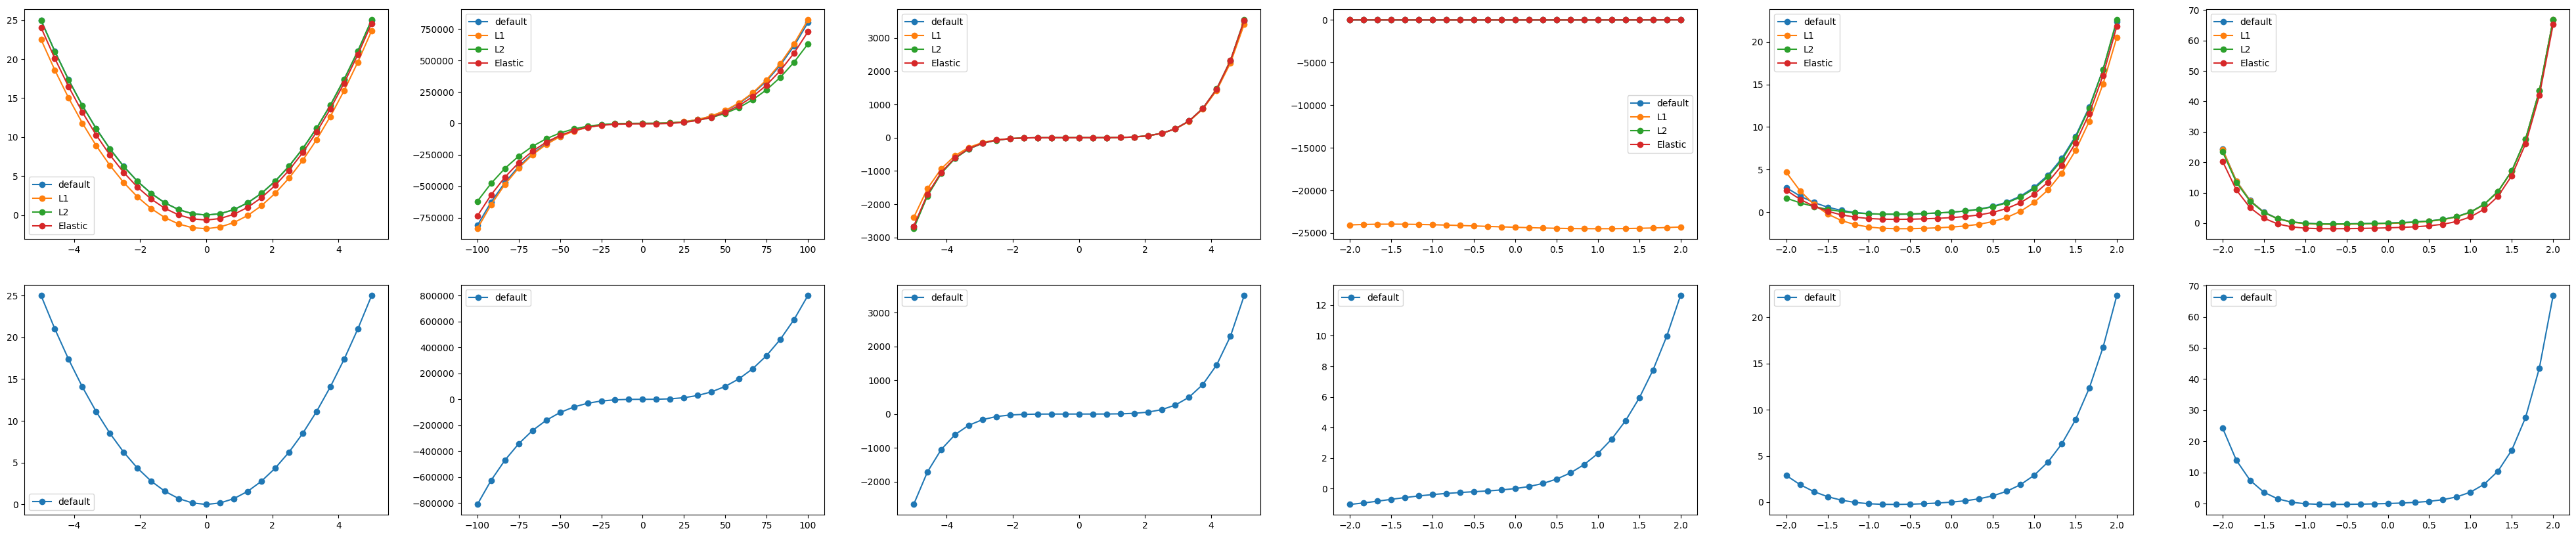

In [ ]:
# @title
plt.rcParams["figure.figsize"] = (50, 10)

fig, ((ax1, ax2, ax3, ax4, ax5, ax6),
      (ax7, ax8, ax9, ax10, ax11, ax12)) = plt.subplots(2, 6)

print("f1 = x^2")
X, Y, start_W = generate_N_polynomial_task_in_R2([1, 0, 0], 1000, dispx=10, disp=0.1)
W, _ = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 100, 1)
print_func_in_R2(W, name="default", dist=5, custom_plt=ax7)
ax7.legend()
print_func_in_R2(W, name="default", dist=5, custom_plt=ax1)
# ax1.legend()
W, _ = SGD_polynomial_MSE_regularizationL1(X, Y, start_W, 0.0001, 100, al_1=0.1)
print_func_in_R2(W, name="L1", dist=5, custom_plt=ax1)
W, _ = SGD_polynomial_MSE_regularizationL2(X, Y, start_W, 0.0001, 100, al_2=0.1)
print_func_in_R2(W, name="L2", dist=5, custom_plt=ax1)
W, _ = SGD_polynomial_MSE_regularization_Elastic(X, Y, start_W, 0.0001, 100, al_1=0.1, al_2=0.1)
print_func_in_R2(W, name="Elastic", dist=5, custom_plt=ax1)
ax1.legend()



X, Y, start_W = generate_N_polynomial_task_in_R2([1, -2, 8, 5], 1000, dispx=5, disp=0.1)
W, _ = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 100, 1)
print_func_in_R2(W, name="default", custom_plt=ax8)
ax8.legend()
print_func_in_R2(W, name="default", custom_plt=ax2)


W, _ = SGD_polynomial_MSE_regularizationL1(X, Y, start_W, 0.0001, 100, al_1=0.1)
print_func_in_R2(W, name="L1", custom_plt=ax2)
W, _ = SGD_polynomial_MSE_regularizationL2(X, Y, start_W, 0.0001, 100, al_2=0.1)
print_func_in_R2(W, name="L2", custom_plt=ax2)
W, _ = SGD_polynomial_MSE_regularization_Elastic(X, Y, start_W, 0.0001, 100, al_1=1, al_2=0.1)
print_func_in_R2(W, name="Elastic", custom_plt=ax2)
ax2.legend()



X, Y, start_W = generate_N_polynomial_task_in_R2([np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand()],
                                                 1000, dispx=2, disp=0.1)
W, _ = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 100, 1)
print_func_in_R2(W, name="default", dist=5, custom_plt=ax9)
ax9.legend()
print_func_in_R2(W, name="default", dist=5, custom_plt=ax3)

W, _ = SGD_polynomial_MSE_regularizationL1(X, Y, start_W, 0.0001, 100, al_1=0.1)
print_func_in_R2(W, name="L1", dist=5, custom_plt=ax3)
W, _ = SGD_polynomial_MSE_regularizationL2(X, Y, start_W, 0.0001, 100, al_2=0.1)
print_func_in_R2(W, name="L2", dist=5, custom_plt=ax3)
W, _ = SGD_polynomial_MSE_regularization_Elastic(X, Y, start_W, 0.0001, 100, al_1=0.1, al_2=0.1)
print_func_in_R2(W, name="Elastic", dist=5, custom_plt=ax3)
ax3.legend()



X, Y, start_W = generate_N_polynomial_task_in_R2([np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand()],
                                                 1000, dispx=2, disp=0.1)
W, _ = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 100, 1)
print_func_in_R2(W, name="default", dist=2, custom_plt=ax10)
ax10.legend()
print_func_in_R2(W, name="default", dist=2, custom_plt=ax4)

W, _ = SGD_polynomial_MSE_regularizationL1(X, Y, start_W, 0.0001, 100, al_1=1)
print_func_in_R2(W, name="L1", dist=2, custom_plt=ax4)
W, _ = SGD_polynomial_MSE_regularizationL2(X, Y, start_W, 0.0001, 100, al_2=1)
print_func_in_R2(W, name="L2", dist=2, custom_plt=ax4)
W, _ = SGD_polynomial_MSE_regularization_Elastic(X, Y, start_W, 0.0001, 100, al_1=1, al_2=1)
print_func_in_R2(W, name="Elastic", dist=2, custom_plt=ax4)
ax4.legend()




X, Y, start_W = generate_N_polynomial_task_in_R2([np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand()],
                                                 1000, dispx=2, disp=0.1)
W, _ = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 100, 1)
print_func_in_R2(W, name="default", dist=2, custom_plt=ax11)
ax11.legend()
print_func_in_R2(W, name="default", dist=2, custom_plt=ax5)

W, _ = SGD_polynomial_MSE_regularizationL1(X, Y, start_W, 0.0001, 100, al_1=0.1)
print_func_in_R2(W, name="L1", dist=2, custom_plt=ax5)
W, _ = SGD_polynomial_MSE_regularizationL2(X, Y, start_W, 0.0001, 100, al_2=0.1)
print_func_in_R2(W, name="L2", dist=2, custom_plt=ax5)
W, _ = SGD_polynomial_MSE_regularization_Elastic(X, Y, start_W, 0.0001, 100, al_1=0.1, al_2=0.1)
print_func_in_R2(W, name="Elastic", dist=2, custom_plt=ax5)
ax5.legend()

X, Y, start_W = generate_N_polynomial_task_in_R2([np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand()],
                                                 1000, dispx=2, disp=0.1)
W, _ = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 100, 1)
print_func_in_R2(W, name="default", dist=2, custom_plt=ax12)
ax12.legend()
print_func_in_R2(W, name="default", dist=2, custom_plt=ax6)

W, _ = SGD_polynomial_MSE_regularizationL1(X, Y, start_W, 0.0001, 100, al_1=0.01)
print_func_in_R2(W, name="L1", dist=2, custom_plt=ax6)
W, _ = SGD_polynomial_MSE_regularizationL2(X, Y, start_W, 0.0001, 100, al_2=0.01)
print_func_in_R2(W, name="L2", dist=2, custom_plt=ax6)
W, _ = SGD_polynomial_MSE_regularization_Elastic(X, Y, start_W, 0.0001, 100, al_1=0.1, al_2=0.01)
print_func_in_R2(W, name="Elastic", dist=2, custom_plt=ax6)
ax6.legend()



Заметим, что регуляризация с коэффициентами $λ=1$ (пример 4) оказывает разрушительное воздействие на восстановление полинома. То есть для более-менее нормальных результатов нам скорее всего следует подбирать меньшую $λ$.

С коэффициентами $λ=0.1$ (примеры 1-3, 5) мы видим более хорошие результаты: $L1$ почти совпадает с дефолтным методом, а $L2$ и $Elastic$ все еще имеют существенную погрешность.

С коэффициентами $λ=0.01$ (пример 6) мы продолжаем наблюдать весьма существенные различия между результатами работы алгоритма.

**Вывод:**

Методы регуляризации излишни и слабо подходят для восстановления полиномов, что логично - так как мы не находимся в ситуации линейно зависимых входных данных.

####Сравнительная сходимость

In [ ]:
#@title
def random_n_polynomial_regression(W, count, dispx=10, disp=0.1):
  n=len(W)-1
  x = np.random.rand(count, n) * dispx
  X = []
  y = []
  for i in x:
    X.append(i)
    x_deg = np.vander(i, N=n+1).T
    e = np.ones(n) @ (W[:-1] * x_deg[:-1]) @ np.ones(n) + W[-1][-1]
    y.append([e + np.random.uniform(-disp, disp)])
  return np.array(X), np.array(y), np.array([[0 for i in range(n)] for i in range(n+1)])

random_n_polynomial_regression(np.array([[1, 2, 0], [5, 6, 0], [0, 10, 0], [0, 0, 1]]), 1)

(array([[9.66832831, 6.06650261, 7.19812235]]),
 array([[2100.20859622]]),
 array([[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]))

In [ ]:
###############TEST

# X, Y, start_W = generate_N_polynomial_task_in_R2([1, -2, 8, 5], 1000, dispx=5, disp=0.1)
# W, _ = SGD_polynomial_MSE(X, Y, start_W, 0.0001, 100, 1)
W, _ = SGD_polynomial_MSE(
    np.array([[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0]]),
    np.array([[1], [4], [9], [16], [25], [36], [49]]),
    np.array([[1, 1], [1, 1], [0, 1]]), 0.00001
)
print(W)

W, _ = SGD_polynomial_MSE_regularizationL2(
    np.array([[1, 0], [2, 0], [3, 0], [4, 0], [5, 0], [6, 0], [7, 0]]),
    np.array([[1], [4], [9], [16], [25], [36], [49]]),
    np.array([[1, 1], [1, 1], [0, 1]]), 0.00001, al_2=100
)
print(W)

[[0.81247755 1.        ]
 [0.94287003 1.        ]
 [0.         0.9799803 ]]
[[0.81162341 0.2428246 ]
 [0.33107833 0.2428246 ]
 [0.         0.25590652]]


 83%|████████▎ | 5/6 [03:45<00:44, 44.48s/it]<ipython-input-39-01202249592a>:9: RuntimeWarning: overflow encountered in square
  return error ** 2
<ipython-input-4-1905a8c91435>:10: RuntimeWarning: overflow encountered in multiply
  ans.append(2 * error * x_deg[i])
<ipython-input-4-1905a8c91435>:11: RuntimeWarning: invalid value encountered in multiply
  ans.append(2 * error * z)
<ipython-input-39-01202249592a>:47: RuntimeWarning: invalid value encountered in subtract
  W = W - lr * gradH_polynomial(X_i, Y_i, W, grL, al_1, al_2)
<ipython-input-39-01202249592a>:14: RuntimeWarning: overflow encountered in square
  return al_1 * np.sum(np.abs(W)) + al_2 * np.sum(W ** 2)
<ipython-input-39-01202249592a>:14: RuntimeWarning: invalid value encountered in double_scalars
  return al_1 * np.sum(np.abs(W)) + al_2 * np.sum(W ** 2)
<ipython-input-39-01202249592a>:27: RuntimeWarning: invalid value encountered in multiply
  return al_1 * np.maximum(1 - W, 0) + al_2 * (2 * W)
<ipython-input-39-01202249

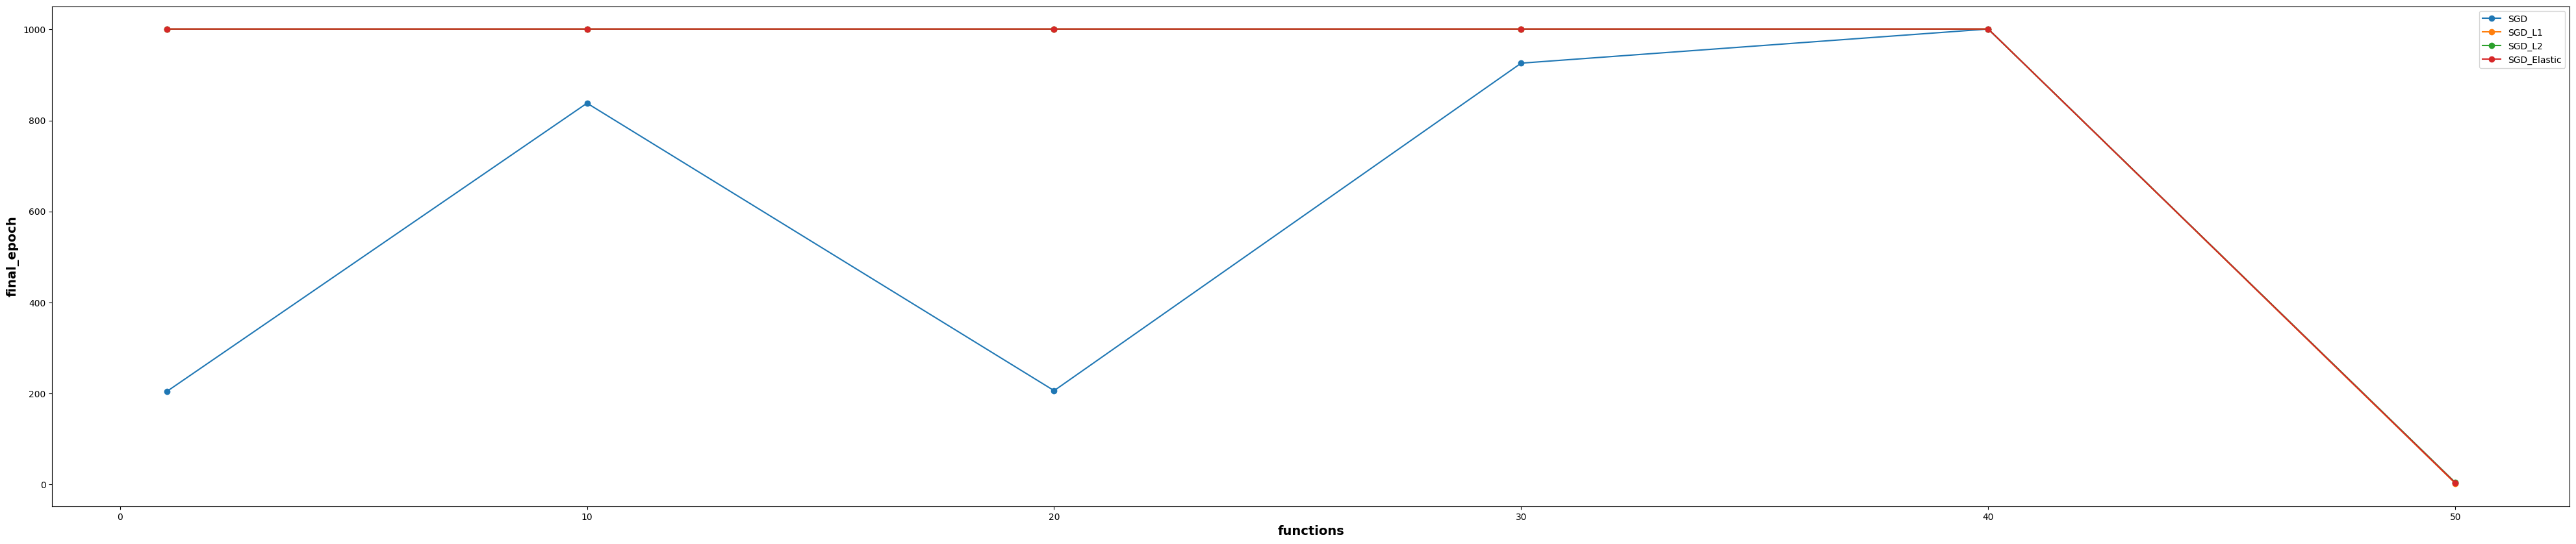

In [ ]:
#@title
#.............
def gen_k(size, dd = 2):
  return (np.random.rand(size+1, size) * dd)

# np.array([[1, 1], [2, 2], [0, 1]]),
#     np.array([[1, 0.6], [4, 5], [0, -1]]

functions = [
    gen_k(5, 1),
    gen_k(5, 1),
    gen_k(3, 1),
    gen_k(4, 2),
    gen_k(2, 2),
    gen_k(10, 0.00001)
]

# print(functions)
full_losts = [[], [], [], []]
for func in tqdm.tqdm(functions):
  # k = (np.random.random(10) * 10).tolist()
  d=0.1
  #(((2*d)**2)/12)
  x, y, start_W = random_n_polynomial_regression(func, 100, dispx=2, disp=0.01)


  _, final_epoch = SGD_polynomial_MSE(x, y, start_W, 0.0001, 1000, 1, eps_stop=0.01)
  full_losts[0].append(final_epoch)


  _, final_epoch = SGD_polynomial_MSE_regularizationL1(x, y, start_W, 0.0001, 1000, al_1=0.01, eps_stop=0.01)
  full_losts[1].append(final_epoch)


  _, final_epoch = SGD_polynomial_MSE_regularizationL2(x, y, start_W, 0.0001, 1000, al_2=0.01, eps_stop=0.01)
  full_losts[2].append(final_epoch)


  _, final_epoch = SGD_polynomial_MSE_regularization_Elastic(x, y, start_W, 0.0001, 1000, al_1=0.01, al_2=0.01, eps_stop=0.01)
  full_losts[3].append(final_epoch)


plt.plot([1, 10, 20, 30, 40, 50], full_losts[0], '-o', label=f"SGD")
plt.plot([1, 10, 20, 30, 40, 50], full_losts[1], '-o', label=f"SGD_L1")
plt.plot([1, 10, 20, 30, 40, 50], full_losts[2], '-o', label=f"SGD_L2")
plt.plot([1, 10, 20, 30, 40, 50], full_losts[3], '-o', label=f"SGD_Elastic")

plt.legend()
plt.ylabel("final_epoch", fontsize=14, fontweight="bold")
plt.xlabel("functions", fontsize=14, fontweight="bold")
plt.show()